# Alibaba evaluate clustering and metadata features with XGBoost

In [1]:
import sys
import logging

## LOGGING
nblog = open("alibaba_data-evaluation.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [2]:
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np

In [3]:
import dask.array as da
import dask.distributed


In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
from scipy.stats import norm
import numpy as np

import matplotlib as mpl
from cycler import cycler
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

In [6]:
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import OneHotEncoder
from scipy.special import softmax

In [9]:
import hdbscan
from sklearn.cluster import OPTICS

In [10]:
from collections import defaultdict
from collections import Counter

In [11]:
import random

In [12]:
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score

In [13]:
import shap

In [14]:
from xgboost import plot_importance

from xgboost import to_graphviz

from sklearn.metrics import classification_report,confusion_matrix

In [15]:
import pickle

## Import data and clustering model

### Load data

In [16]:
sampled_workload_data = pd.read_csv('experiments/100_001_sampled_workload_data.csv', index_col=0)
sampled_workload_data.drop('index', axis=1, inplace=True)

sampled_workload_data
sampled_workload_data[(sampled_workload_data.inst_id == 'c5be8813bf90aaf9ca6f02f744ccd95596e9850928a498a2100865912a93') & (sampled_workload_data.task_name == 'ps')][['worker_name', 'job_name', 'task_name', 'inst_name',
                                                                                                                            'inst_id', 'inst_num', 'start_time', 'end_time', 'cpu_usage', 'plan_cpu']]

,worker_name,job_name,task_name,inst_name,inst_id,inst_num,start_time,end_time,cpu_usage,plan_cpu
0,04e8a1d93c8a93a3a0a10466cd2f25132dd14c73293d24...,71712e3c961b5bbdb2ce0440,ps,c2e0be7577f427c47d77dd388f5bad181447f0bd21bc9e...,c5be8813bf90aaf9ca6f02f744ccd95596e9850928a498...,5.0,4625696.0,4628399.0,34.465789,600.0
31,7305f2e47403fa1884368999187d296d7be13848210f0b...,71712e3c961b5bbdb2ce0440,ps,0f5096d5beef8966e7a48b389a930ce6ac60d00b8f5204...,c5be8813bf90aaf9ca6f02f744ccd95596e9850928a498...,5.0,4625696.0,4628399.0,29.839050,600.0
263,40e6fa33245bf4c009d38cc092b63e16431118de5dd7fb...,71712e3c961b5bbdb2ce0440,ps,21959d0ef804918315225ae4690fc4fee6fe2f9e14c26a...,c5be8813bf90aaf9ca6f02f744ccd95596e9850928a498...,5.0,4625696.0,4628399.0,28.737533,600.0
310,e866763111170d4e83736b7cf01fe28931b25eedf27ae8...,71712e3c961b5bbdb2ce0440,ps,4e2d8cc1232cf8ff71cc6a1b1c97f3e06cead3837773e2...,c5be8813bf90aaf9ca6f02f744ccd95596e9850928a498...,5.0,4625696.0,4628399.0,28.986911,600.0
329,03fe7de6f20cff030805d49ec18ed04ff7674405b46e82...,71712e3c961b5bbdb2ce0440,ps,9c25ce0eaafa029e0bd8761255c95a75afcf073a04bf01...,c5be8813bf90aaf9ca6f02f744ccd95596e9850928a498...,5.0,4625696.0,4628399.0,29.493438,600.0
...,...,...,...,...,...,...,...,...,...,...
29282,e484762321e8cbb7b08bddd588e191b149a5d24cb5eeec...,71712e3c961b5bbdb2ce0440,ps,0efd8a37c7d11cc9cc1d6dddeb6f6e0fbd60244f487ab8...,c5be8813bf90aaf9ca6f02f744ccd95596e9850928a498...,5.0,4625696.0,4628399.0,34.910761,600.0
29567,ede5843642f408607a2956b0bc9424ad6545a581a90bdb...,71712e3c961b5bbdb2ce0440,ps,c302b8847e929e8d2a1f01bec43b9b078d96192c879e68...,c5be8813bf90aaf9ca6f02f744ccd95596e9850928a498...,5.0,4625696.0,4628399.0,30.685039,600.0
29583,4c6d70bbafb59647527a91021a245af8f245cf691ad969...,71712e3c961b5bbdb2ce0440,ps,49f1d874326711295999f709382d5b75b99a52d0632aa6...,c5be8813bf90aaf9ca6f02f744ccd95596e9850928a498...,5.0,4625696.0,4628399.0,28.392105,600.0
29635,03be45a263c48322ee3d00151740740edf25c325b54aa0...,71712e3c961b5bbdb2ce0440,ps,4f4e67a00f97b5dc610dfbc2c3652ff47c7d2574562655...,c5be8813bf90aaf9ca6f02f744ccd95596e9850928a498...,5.0,4625696.0,4628399.0,60.886842,600.0


In [17]:
example_instances_df = sampled_workload_data.groupby(['inst_id', 'worker_name', 'task_name'])[['cpu_usage', 'plan_cpu', 'inst_num', 'start_time']].agg(['min', 'max', 'sum'])
example_instances_df

cpu_usage  \
                                                                                                                        min   
inst_id                                            worker_name                                        task_name               
0000cecf2d945a238b7a4273330da58bb6c674820134d50... 76e718c1772fb846f70b3259030e465655762b19de4c090... ps          97.657143   
                                                   a66a1249eff003f1844feb7f65039913c5f2eadb7abca4f... worker     104.000000   
                                                   dd9b20a11a2256ff213c963452a4b2b49c6a36bf230e383... worker     100.787879   
                                                   eac810f40221c75bad6a976c12566736e0ee9bf931611ca... worker     103.000000   
                                                   f0931bb0e9c021cea8d568cd49a05507374452f86f50b18... ps          99.586207   
...                                                                                                                     ...   
fffbb106ee016014d42f08736a36ea75523f93a82f64140... caf64887f605852f441406b9857197ba7fd419d503bc697... worker     154.814815   
                                                   cd10419e29edfb06e7e756a98d1968bc401d3f65ca3d07a... ps         170.650000   
                                                   dc44242c6dc6e15bdff6c73399d759b0d690b4c28a2d363... worker     131.257576   
                                                   eea6cac8987ac4a5a08e69e57b29403d01231286313515d... ps         192.250000   
                                                   f8bfa513f36b44cdc1386db20e0543633c870709d76caf9... worker     170.650000   

                                                                                                                             \
                                                                                                                        max   
inst_id                                            worker_name                                        task_name               
0000cecf2d945a238b7a4273330da58bb6c674820134d50... 76e718c1772fb846f70b3259030e465655762b19de4c090... ps         119.247423   
                                                   a66a1249eff003f1844feb7f65039913c5f2eadb7abca4f... worker     104.000000   
                                                   dd9b20a11a2256ff213c963452a4b2b49c6a36bf230e383... worker     100.787879   
                                                   eac810f40221c75bad6a976c12566736e0ee9bf931611ca... worker     103.000000   
                                                   f0931bb0e9c021cea8d568cd49a05507374452f86f50b18... ps          99.586207   
...                                                                                                                     ...   
fffbb106ee016014d42f08736a36ea75523f93a82f64140... caf64887f605852f441406b9857197ba7fd419d503bc697... worker     154.814815   
                                                   cd10419e29edfb06e7e756a98d1968bc401d3f65ca3d07a... ps         170.650000   
                                                   dc44242c6dc6e15bdff6c73399d759b0d690b4c28a2d363... worker     131.257576   
                                                   eea6cac8987ac4a5a08e69e57b29403d01231286313515d... ps         192.250000   
                                                   f8bfa513f36b44cdc1386db20e0543633c870709d76caf9... worker     170.650000   

                                                                                                                             \
                                                                                                                        sum   
inst_id                                            worker_name                                        task_name               
0000cecf2d945a238b7a4273330da58bb6c674820134d50... 76e718c1772fb846f70b3259030e465655762b19de4c090... ps         216.904566   
                                                

In [18]:
example_instances_df[(example_instances_df[('inst_num', 'max')] / example_instances_df[('inst_num', 'sum')]) <= 0.25] 

cpu_usage  \
                                                                                                                       min   
inst_id                                            worker_name                                        task_name              
06dee78a26c92f39c6ed1d544a735d39fa301931872f25d... 0a7d7a4c43e644531368c57608bf3fb8f7ab97de8dd299f... ps         13.973516   
                                                   6df700c86fdaae6390c6b732237af723d8f4500cf69d526... worker     13.050274   
                                                   84fb633fa5f6c179eba92b8d0d4cf271131cfbca37a6837... ps         15.157365   
08d8b49ff40ad664584d18157a0fca15592b2c9d26d4ac0... 58b10ffd9b0d14b5a26e80d52a3178ca2d75075248eacbf... worker     27.276968   
0f392e7c43ff64b0ea0e7922e9f3d09d11517c9ec10003b... a51d949e7dc1924d17b4054486c5d28f0f53df0aaee1b56... worker     26.700906   
...                                                                                                                    ...   
f39385f1d539e6b389648e0fe8eea1f9500b30b7bb32367... 67296b0ee3a8300b3cfc42089abf6751f9dde554f9b5aa4... ps         80.694301   
                                                   9a3515255cd4ab5413d7fee2f433e65c3addcae91abb26e... worker     84.140260   
                                                   f5b209444e29ce5a0ae80f92a65aa956e12ce37022130b1... ps         78.841146   
f593c799ada9c210bedfac8ed673ec4bc77a2cbfb32d368... 257e856689f54c92d4b8fff8def5ca0b4e4cfadb7ae0620... worker     79.735294   
fab6a8c48323c5ce88be28e74b7dd3710d20276fa185606... 4acfee0e5860888c88822ed92fd016f481255282c0c07ab... ps         38.750000   

                                                                                                                            \
                                                                                                                       max   
inst_id                                            worker_name                                        task_name              
06dee78a26c92f39c6ed1d544a735d39fa301931872f25d... 0a7d7a4c43e644531368c57608bf3fb8f7ab97de8dd299f... ps         25.011872   
                                                   6df700c86fdaae6390c6b732237af723d8f4500cf69d526... worker     20.533394   
                                                   84fb633fa5f6c179eba92b8d0d4cf271131cfbca37a6837... ps         27.669716   
08d8b49ff40ad664584d18157a0fca15592b2c9d26d4ac0... 58b10ffd9b0d14b5a26e80d52a3178ca2d75075248eacbf... worker     65.674487   
0f392e7c43ff64b0ea0e7922e9f3d09d11517c9ec10003b... a51d949e7dc1924d17b4054486c5d28f0f53df0aaee1b56... worker     64.374622   
...                                                                                                                    ...   
f39385f1d539e6b389648e0fe8eea1f9500b30b7bb32367... 67296b0ee3a8300b3cfc42089abf6751f9dde554f9b5aa4... ps         99.859740   
                                                   9a3515255cd4ab5413d7fee2f433e65c3addcae91abb26e... worker     96.844156   
                                                   f5b209444e29ce5a0ae80f92a65aa956e12ce37022130b1... ps         98.197403   
f593c799ada9c210bedfac8ed673ec4bc77a2cbfb32d368... 257e856689f54c92d4b8fff8def5ca0b4e4cfadb7ae0620... worker     84.424242   
fab6a8c48323c5ce88be28e74b7dd3710d20276fa185606... 4acfee0e5860888c88822ed92fd016f481255282c0c07ab... ps         63.666667   

                                                                                                                             \
                                                                                                                        sum   
inst_id                                            worker_name                                        task_name               
06dee78a26c92f39c6ed1d544a735d39fa301931872f25d... 0a7d7a4c43e644531368c57608bf3fb8f7ab97de8dd299f... ps          70.624282   
                                                   6df700c86fdaae6390c6b732

In [19]:
dynamic_workload_data_df = sampled_workload_data[list(sampled_workload_data.select_dtypes(include=[np.number]).columns.values)].fillna(0,)
dynamic_workload_data_df

,inst_num,start_time,end_time,plan_cpu,plan_mem,plan_gpu,cpu_usage,gpu_wrk_util,avg_mem,max_mem,avg_gpu_wrk_mem,max_gpu_wrk_mem,read,write,read_count,write_count,duration
0,5.0,4625696.0,4628399.0,600.0,29.296875,0.0,34.465789,7.541667,1.204708,2.723633,0.347158,0.829102,2.068066e+06,3.426616e+05,312.218182,219.376623,2703.0
1,5.0,4642480.0,4644075.0,600.0,29.296875,0.0,52.794326,12.049123,1.505760,2.671875,0.445045,0.827148,1.234028e+06,3.724553e+05,264.849650,173.374126,1595.0
2,16.0,4058070.0,4058321.0,50.0,29.296875,100.0,75.052632,23.727273,1.037900,1.853516,0.445890,0.774414,1.010761e+07,3.781242e+06,2401.913043,590.652174,251.0
3,5.0,4642480.0,4644075.0,600.0,29.296875,0.0,92.604240,11.706294,1.481600,2.667969,0.449140,0.829102,2.358233e+06,4.527896e+05,404.843206,271.797909,1595.0
4,2.0,5521030.0,5526746.0,600.0,20.000000,0.0,110.590788,13.005300,2.357810,3.056641,0.645605,0.827148,1.037695e+06,1.527555e+05,201.449250,181.084731,5716.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,1.0,5890601.0,5893675.0,600.0,29.296875,0.0,127.340568,81.609635,1.940527,1.995117,1.200031,1.213867,1.941028e+06,1.165604e+06,402.442786,171.301824,3074.0
99997,3.0,4297415.0,4306572.0,600.0,29.296875,0.0,94.920180,85.691919,1.803602,2.001953,1.975061,2.213867,1.035467e+06,4.269076e+05,259.100393,115.694335,9157.0
99998,5.0,5448779.0,5450118.0,600.0,29.296875,0.0,105.585657,44.271654,1.859159,2.024414,1.172409,1.213867,3.300603e+06,3.495205e+06,568.968627,295.933333,1339.0
99999,5.0,5822706.0,5822846.0,600.0,29.296875,0.0,28.250000,0.000000,0.341797,0.735352,0.000000,0.000000,5.726675e+07,6.596024e+07,8070.600000,3965.400000,140.0


### Load cluster search analyis

In [20]:
from importlib import reload

In [22]:
sns.__version__
sns.lineplot

<function seaborn.relational.lineplot(data=None, *, x=None, y=None, hue=None, size=None, style=None, units=None, palette=None, hue_order=None, hue_norm=None, sizes=None, size_order=None, size_norm=None, dashes=True, markers=None, style_order=None, estimator='mean', errorbar=('ci', 95), n_boot=1000, seed=None, orient='x', sort=True, err_style='band', err_kws=None, legend='auto', ci='deprecated', ax=None, **kwargs)>

In [23]:
min_cluster_size

NameError: name 'min_cluster_size' is not defined

In [24]:
OPTICS_analysis_df = pd.read_csv('experiments/01_optics_analysis.csv')
HDBSCAN_analysis_df = pd.read_csv('experiments/01_hdbscan_analysis.csv')

In [25]:
HDBSCAN_analysis_df

,Unnamed: 0,transform_function,metric,min_cluster_size,n_outliers,n_clusters,mean_cluster_size,avg_silhouette,davies_bouldin_score,scores_v1,scores_v3,CCPM
0,0,standard_scaler,euclidean,50,30704,191,362.811518,0.350757,1.282518,0.393282,0.500397,1.130473
1,1,standard_scaler,manhattan,50,31130,199,346.085427,0.440876,1.266020,0.420077,0.533767,1.230753
2,2,standard_scaler,euclidean,100,35737,115,558.817391,0.387783,1.328413,0.418835,0.499039,1.140561
3,3,standard_scaler,manhattan,100,39103,124,491.112903,0.468857,1.294141,0.429169,0.512998,1.241570
4,4,standard_scaler,euclidean,200,38760,53,1155.490566,0.439505,1.445859,0.514158,0.531061,1.131135
5,5,standard_scaler,manhattan,200,45384,54,1011.425926,0.517696,1.389021,0.515114,0.528309,1.237627
6,6,standard_scaler,euclidean,300,36153,30,2128.266667,0.348775,1.528851,0.617972,0.545413,1.002861
7,7,standard_scaler,manhattan,300,42390,28,2057.535714,0.497840,1.521960,0.667505,0.580045,1.154887
8,8,standard_scaler,euclidean,400,37221,23,2729.565217,0.381708,1.732552,0.631372,0.555042,0.958891
9,9,standard_scaler,manhattan,400,44775,20,2761.300000,0.516178,1.682370,0.612554,0.559521,1.110577


In [26]:
OPTICS_analysis_df.describe()

,Unnamed: 0,min_cluster_size,n_outliers,n_clusters,mean_cluster_size,avg_silhouette,davies_bouldin_score,scores_v1,scores_v3,CCPM
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,27.500000,378.571429,79578.250000,66.214286,889.477000,0.636549,1.191900,0.420308,0.398747,1.481452
std,16.309506,309.670961,7643.202908,79.340398,752.125585,0.231637,0.099930,0.134276,0.116682,0.219209
min,0.000000,50.000000,66708.000000,1.000000,120.636364,-1.000000,0.977568,-0.313963,-0.386329,-0.010187
25%,13.750000,100.000000,73683.750000,11.750000,254.003202,0.626744,1.131935,0.351854,0.386406,1.446346
50%,27.500000,300.000000,79251.000000,29.500000,714.985714,0.677351,1.194583,0.422124,0.422129,1.497519
75%,41.250000,600.000000,84823.000000,102.750000,1130.611111,0.709395,1.264104,0.501774,0.445099,1.574073
max,55.000000,1000.000000,98036.000000,271.000000,2979.500000,0.818679,1.401589,0.625958,0.487297,1.782349


In [27]:
OPTICS_analysis_df.groupby('min_cluster_size')['scores_v1'].max()

min_cluster_size
50      0.375767
100     0.403986
200     0.508466
300     0.625958
400     0.577022
600     0.537418
1000    0.465391
Name: scores_v1, dtype: float64



The `ci` parameter is deprecated. Use `errorbar=('ci', 0)` for the same effect.



The `ci` parameter is deprecated. Use `errorbar=('ci', 0)` for the same effect.



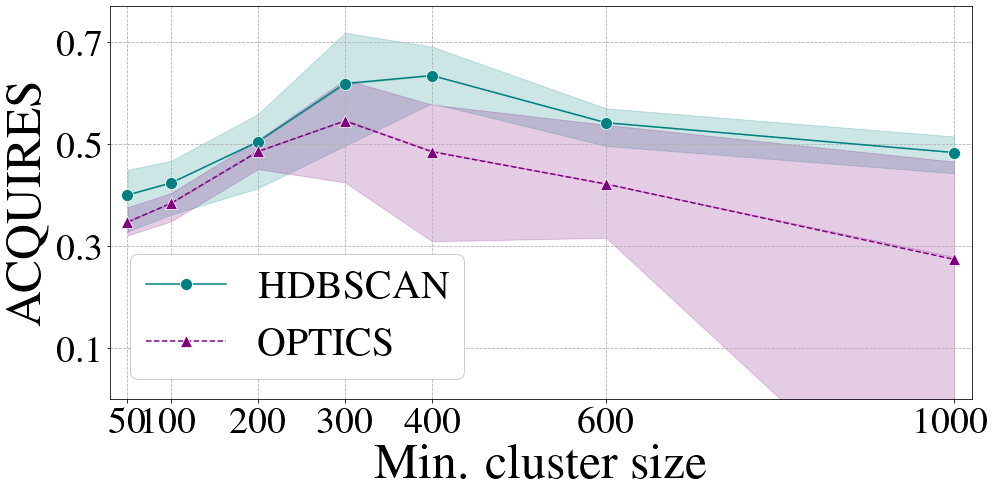

In [28]:
min_cluster_size = [50, 100, 200, 300, 400, 600, 1_000]

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Times"
})

    
    



plt.figure(figsize=(14,7))
sns.lineplot(x=HDBSCAN_analysis_df.min_cluster_size, y=HDBSCAN_analysis_df.scores_v1, color="teal", linestyle="-", marker="o", markersize=12, 
             label='HDBSCAN', ci=0)

plt.fill_between(min_cluster_size, HDBSCAN_analysis_df.groupby('min_cluster_size')['scores_v1'].min().values, HDBSCAN_analysis_df.groupby('min_cluster_size')['scores_v1'].max().values,
                facecolor='teal', edgecolor='teal', alpha=0.2)


sns.lineplot(x=OPTICS_analysis_df.min_cluster_size, y=OPTICS_analysis_df.scores_v1, color="purple", linestyle="--", marker="^", markersize=12, 
             label='OPTICS', ci=0)

plt.fill_between(min_cluster_size, OPTICS_analysis_df.groupby('min_cluster_size')['scores_v1'].min().values, OPTICS_analysis_df.groupby('min_cluster_size')['scores_v1'].max().values,
                facecolor='purple', edgecolor='purple', alpha=0.2)


plt.legend(facecolor='white', loc='lower left', framealpha=1, fontsize=40)

plt.ylabel('ACQUIRES', fontsize=50)
plt.xlabel('Min. cluster size', fontsize=50)
plt.xticks(min_cluster_size, min_cluster_size, fontsize=38)
plt.yticks(np.round(np.arange(0.1, 0.9, 0.2), 2), np.round(np.arange(0.1, 0.9, 0.2), 2), fontsize=38)
plt.xlim((30,1020))

plt.ylim(bottom=0.0)

plt.grid(axis='both', linestyle='--')
plt.tight_layout()
plt.savefig('Figures/NSDI_paper/min_clust_size-scorev1-rel.pdf', format='pdf', dpi=1000)



The `ci` parameter is deprecated. Use `errorbar=('ci', 0)` for the same effect.



The `ci` parameter is deprecated. Use `errorbar=('ci', 0)` for the same effect.



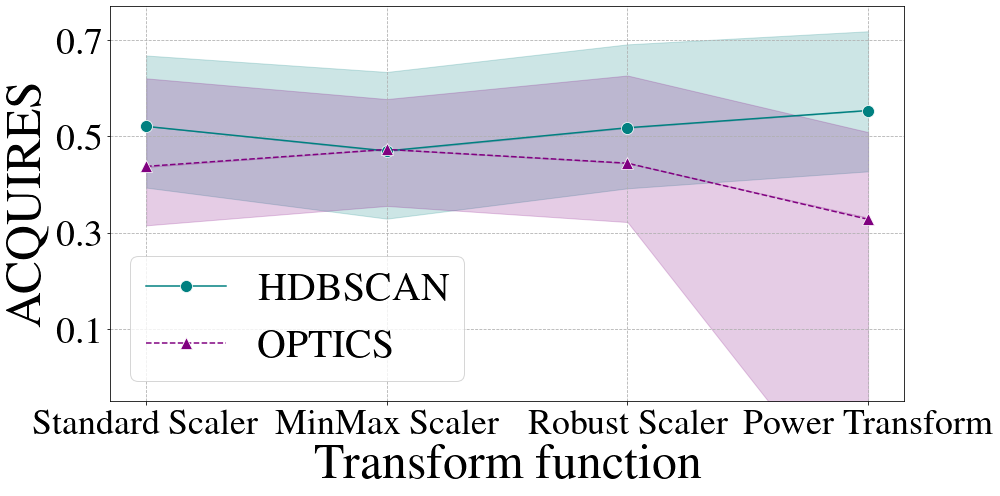

In [29]:
plt.figure(figsize=(14,7))
sns.lineplot(x=HDBSCAN_analysis_df.transform_function, y=HDBSCAN_analysis_df.scores_v1, color="teal", linestyle="-", marker="o", markersize=12, 
             label='HDBSCAN', ci=0) # errorbar=('ci',100))

hdbscan_y_min = [HDBSCAN_analysis_df.groupby('transform_function')['scores_v1'].min().to_dict()[x] for x in ['standard_scaler', 'minmax_scaler', 'robust_scaler', 'yeo-johnson']]
hdbscan_y_max = [HDBSCAN_analysis_df.groupby('transform_function')['scores_v1'].max().to_dict()[x] for x in ['standard_scaler', 'minmax_scaler', 'robust_scaler', 'yeo-johnson']]

plt.fill_between(['standard_scaler', 'minmax_scaler', 'robust_scaler', 'yeo-johnson'], hdbscan_y_min, hdbscan_y_max,
                facecolor='teal', edgecolor='teal', alpha=0.2)


optics_y_min = [OPTICS_analysis_df.groupby('transform_function')['scores_v1'].min().to_dict()[x] for x in ['standard_scaler', 'minmax_scaler', 'robust_scaler', 'yeo-johnson']]
optics_y_max = [OPTICS_analysis_df.groupby('transform_function')['scores_v1'].max().to_dict()[x] for x in ['standard_scaler', 'minmax_scaler', 'robust_scaler', 'yeo-johnson']]


sns.lineplot(x=OPTICS_analysis_df.transform_function, y=OPTICS_analysis_df.scores_v1, color="purple", linestyle="--", marker="^", markersize=12, 
             label='OPTICS', ci=0)
plt.fill_between(['standard_scaler', 'minmax_scaler', 'robust_scaler', 'yeo-johnson'], optics_y_min, optics_y_max,
                facecolor='purple', edgecolor='purple', alpha=0.2)


plt.legend(facecolor='white', loc='lower left', fontsize=40)


plt.ylabel('ACQUIRES', fontsize=50)
plt.xlabel('Transform function', fontsize=50)
plt.xticks(range(4), ['Standard Scaler', 'MinMax Scaler', 'Robust Scaler', 'Power Transform'], fontsize=36, rotation=0)
plt.yticks(np.round(np.arange(0.1, 0.9, 0.2), 2), np.round(np.arange(0.1, 0.9, 0.2), 2), fontsize=38)

plt.ylim(bottom=-0.05)



plt.grid(axis='both', linestyle='--')
plt.tight_layout()
plt.savefig('Figures/NSDI_paper/transf_func-scorev1-rel.pdf', format='pdf', dpi=1000)

In [30]:
HDBSCAN_analysis_df.groupby('transform_function')['scores_v1'].max()

transform_function
minmax_scaler      0.633314
robust_scaler      0.690602
standard_scaler    0.667505
yeo-johnson        0.717785
Name: scores_v1, dtype: float64



The `ci` parameter is deprecated. Use `errorbar=('ci', 0)` for the same effect.



The `ci` parameter is deprecated. Use `errorbar=('ci', 0)` for the same effect.



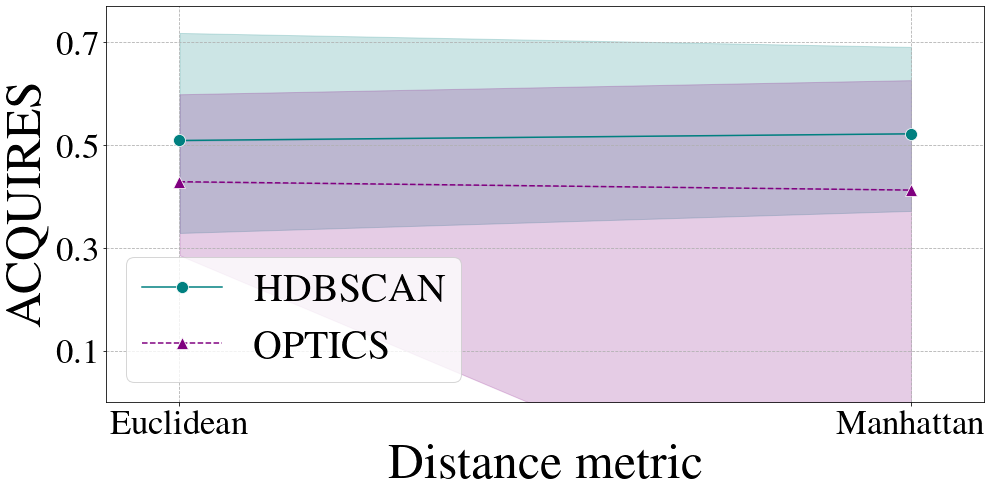

In [31]:
plt.figure(figsize=(14,7))


hdbscan_y_min = [HDBSCAN_analysis_df.groupby('metric')['scores_v1'].min().to_dict()[x] for x in ['euclidean', 'manhattan']]
hdbscan_y_max = [HDBSCAN_analysis_df.groupby('metric')['scores_v1'].max().to_dict()[x] for x in ['euclidean', 'manhattan']]


sns.lineplot(x=HDBSCAN_analysis_df.metric, y=HDBSCAN_analysis_df.scores_v1, color="teal", linestyle="-", marker="o", markersize=12, 
             label='HDBSCAN', ci=0)

plt.fill_between(['euclidean', 'manhattan'], hdbscan_y_min, hdbscan_y_max,
                facecolor='teal', edgecolor='teal', alpha=0.2)


optics_y_min = [OPTICS_analysis_df.groupby('metric')['scores_v1'].min().to_dict()[x] for x in ['euclidean', 'manhattan']]
optics_y_max = [OPTICS_analysis_df.groupby('metric')['scores_v1'].max().to_dict()[x] for x in ['euclidean', 'manhattan']]


sns.lineplot(x=OPTICS_analysis_df.metric, y=OPTICS_analysis_df.scores_v1, color="purple", linestyle="--", marker="^", markersize=12, 
             label='OPTICS', ci=0)
plt.fill_between(['euclidean', 'manhattan'], optics_y_min, optics_y_max,
                facecolor='purple', edgecolor='purple', alpha=0.2)



plt.legend(facecolor='white', loc='lower left', fontsize=40)

plt.ylabel('ACQUIRES', fontsize=50)
plt.xlabel('Distance metric', fontsize=50)
plt.xticks(range(2), ['Euclidean', 'Manhattan'], fontsize=35)


threshold_range = list(np.round(np.arange(0.1, 0.9, 0.2), 2))
plt.yticks(threshold_range, threshold_range, fontsize=35)
plt.ylim(bottom=0.0)
plt.xlim(left=-0.1, right=1.1)

plt.grid(axis='both', linestyle='--')
plt.tight_layout()

plt.savefig('Figures/NSDI_paper/dist_metric-scorev1-rel.pdf', format='pdf', dpi=1000)

### Load cluster results

In [32]:
def plot_silhouette_results(cluster_labels, silhouette_avg, sample_silhouette_values, n_clusters, multiplier=10000, le_name_mapping=None):
    plt.figure(figsize=(12, 12))

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    plt.xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    #plt.ylim([0, len(scaled) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i 

        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        if le_name_mapping:
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, le_name_mapping[i])
        else:
            # Label the silhouette plots with their cluster numbers at the middle
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + multiplier  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.      
    
    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks([-1., -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

SyntaxError: invalid syntax (<ipython-input-32-72704e2669b6>, line 44)

In [33]:
hdbscan_clusterer = pickle.load(open("experiments/hdbscan_300_power_transform_euclidean.pkl", "rb"))

In [34]:
len(hdbscan_clusterer.labels_)

100001

In [35]:
mask = np.array([1 if x>-1 else 0 for x in hdbscan_clusterer.labels_])
mask

array([1, 1, 1, ..., 1, 0, 0])

#### Extract labels that are not noise

In [36]:
hdbscan_notnoise_labels = hdbscan_clusterer.labels_[mask.astype(bool)]

#### Plot clusters results

In [37]:
scaled_values = power_transform(dynamic_workload_data_df.values)

In [38]:
silhouette_HDBSCAN = silhouette_samples(scaled_values, hdbscan_clusterer.labels_, metric='euclidean')

In [39]:
silhouette_masked = silhouette_HDBSCAN[mask.astype(bool)]

In [40]:
silhouette_masked.mean()

0.3993821582845792

In [41]:
silhouette_HDBSCAN

array([ 0.4321273 ,  0.46001087,  0.50139977, ...,  0.26454009,
       -0.38508142, -0.27055746])

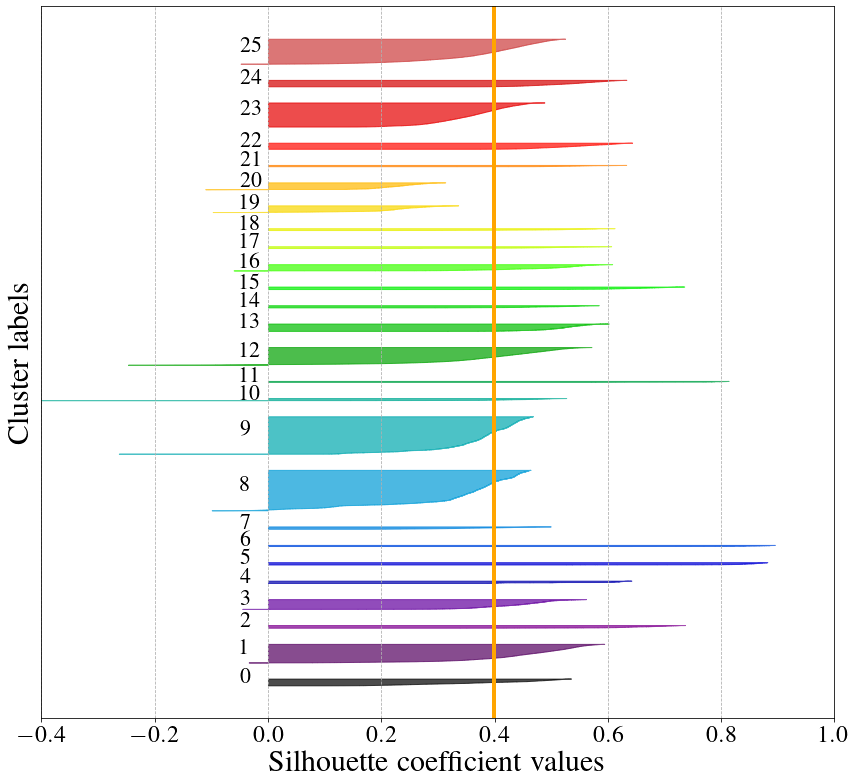

In [42]:
cluster_labels = hdbscan_clusterer.labels_
silhouette_avg = silhouette_masked.mean()
sample_silhouette_values = silhouette_HDBSCAN
n_clusters=max(hdbscan_clusterer.labels_) + 1
multiplier=5_000
le_name_mapping=None

plt.figure(figsize=(12, 11))

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
plt.xlim([-0.4, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
#plt.ylim([0, len(scaled) + (n_clusters + 1) * 10])

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i 

    color = cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    if le_name_mapping:
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, le_name_mapping[i])
    else:
        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=22)

    # Compute the new y_lower for next plot
    y_lower = y_upper + multiplier  # 10 for the 0 samples


plt.xlabel("Silhouette coefficient values", fontsize=30)
plt.ylabel("Cluster labels", fontsize=30)


# The vertical line for average silhouette score of all the values
plt.axvline(x=silhouette_avg, color="orange", linewidth=4, linestyle="-")



plt.yticks([])  # Clear the yaxis labels / ticks
plt.xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=24)

plt.grid(axis='both', linestyle='--')

plt.tight_layout()
plt.savefig('Figures/NSDI_paper/HDBSCAN_silh_results.pdf',  format='pdf')

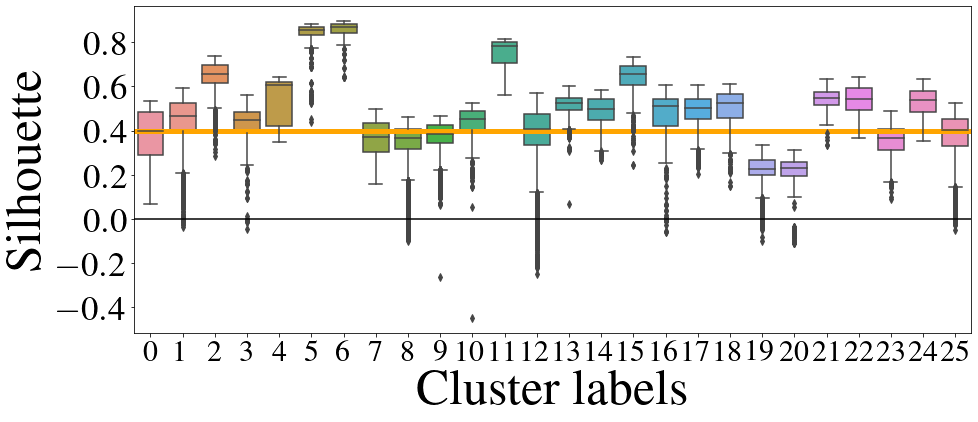

In [43]:
df_silh_labels_boxplot= pd.DataFrame(dict(silh=silhouette_masked, lab=hdbscan_notnoise_labels))

plt.figure(figsize=(15, 6))


text_fontsize=40
textbox_alpha=0.3

label_size=50
ticks_size=35

plt.axhline(y=silhouette_avg, color='orange', linewidth=5)

sns.boxplot(x='lab', y='silh', data=df_silh_labels_boxplot)

plt.axhline(y=0.0, color='k')
plt.xlabel('Cluster labels', fontsize=label_size)
plt.ylabel('Silhouette', fontsize=label_size)
plt.xticks(fontsize=ticks_size-5)
plt.yticks(fontsize=ticks_size)

plt.savefig('Figures/NSDI_paper/HDBSCAN_silh_results_box.pdf',  format='pdf', bbox_inches='tight')

## Interpretation cluster

### Extrapolate dynamic workload data

In [44]:
# Set style values for the boxplots


text_fontsize=40
textbox_alpha=0.3

label_size=50
ticks_size=35

figsize=(13, 12)

figparams = {'format': 'pdf', 
             #'dpi':1000
            }

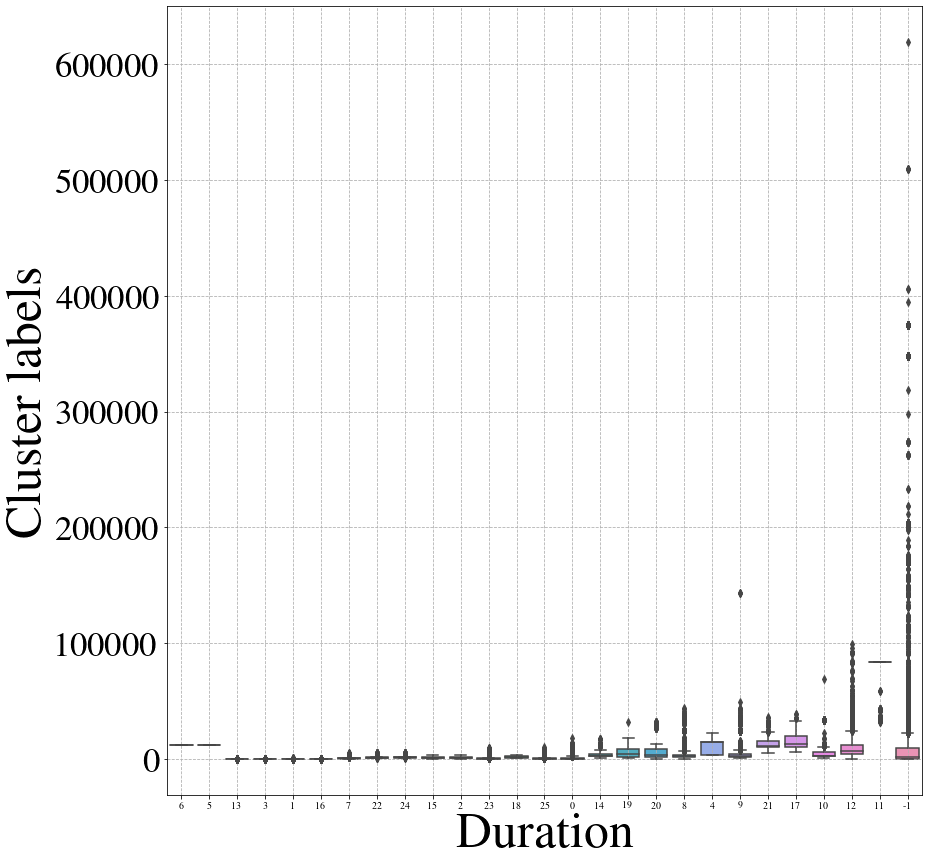

In [45]:
plt.figure(figsize=figsize)

df = pd.DataFrame(dict(duration=sampled_workload_data["duration"], clusters=[str(x) for x in hdbscan_clusterer.labels_]))
my_order = df.groupby(by=["clusters"])["duration"].std().sort_values(ascending=True).to_dict()
# my_order = [str(x) for x in range(25, -2, -1)]

sns.boxplot(x='clusters', y='duration', data=df, order=my_order)

#plt.text(57_000, 1,
#         r'min std = %.1f*$(10^3)$\\ cluster %s, cluster %s' % (my_order[[x for x in my_order.keys()][0]] / 1_000, 
#                                                      [x for x in my_order.keys()][0],
#                                                     [x for x in my_order.keys()][1]),
#         bbox=dict(facecolor='green',
#                   alpha=textbox_alpha),
#         fontsize=text_fontsize)
#
#plt.text(57_000, 5,
#         r'max std = %.1f*$(10^3)$\\ outliers %s' % (my_order[[x for x in my_order.keys()][-1]] / 1_000, [x for x in my_order.keys()][-1]),
#         bbox=dict(facecolor='red',
#                   alpha=textbox_alpha),
#         fontsize=text_fontsize)
# 
#    
#plt.text(np.mean([e for e in my_order.values()]) + 1_200, 3.5,
#         r'avg std = %.1f*$(10^3)$' % (np.mean([e for e in my_order.values()]) / 1_000),
#         bbox=dict(facecolor='deepskyblue',
#                   alpha=textbox_alpha),
#         fontsize=text_fontsize)
#
#plt.axvline(x=np.mean([e for e in my_order.values()]), color='deepskyblue', ls='--', lw=4)

#plt.text(95, 0.07,
#         'Points beyond beyond 75% value',
#         bbox=dict(facecolor='pink',
#                   alpha=0.5),
#         horizontalalignment='right',
#         fontsize=12)
# 
#plt.xlim((0, 110_000))

#plt.xlabel('Duration', fontsize=label_size)
plt.xlabel(r'{\fontsize{50pt}{3em}\selectfont{}Duration }')
plt.ylabel('Cluster labels', fontsize=label_size)
#plt.xticks(range(0, 110_000, 20_000), range(0, 110, 20), fontsize=ticks_size)
plt.yticks(fontsize=ticks_size)

plt.grid(axis='both', linestyle='--')


#plt.text(105_000, 27.5,
#         r'*$(10^3)$',
#         bbox=dict(facecolor='white',
#               alpha=1),
#         fontsize=(28))

plt.tight_layout()
#plt.savefig('Figures/NSDI_paper/HDBSCAN_boxplot_std_duration.pdf', **figparams)

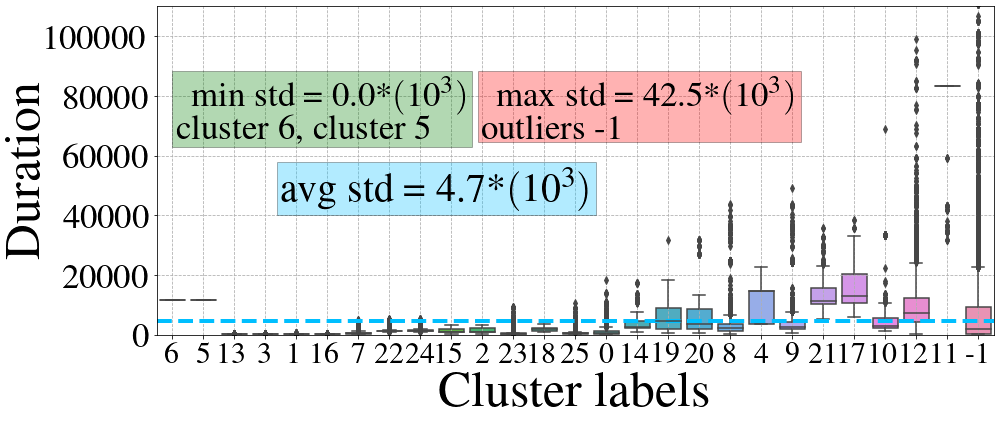

In [46]:
plt.figure(figsize=(14, 6))

df = pd.DataFrame(dict(duration=sampled_workload_data["duration"], clusters=[str(x) for x in hdbscan_clusterer.labels_]))
my_order = df.groupby(by=["clusters"])["duration"].std().sort_values(ascending=True).to_dict()
# my_order = [str(x) for x in range(25, -2, -1)]

sns.boxplot(x='clusters', y='duration', data=df, order=my_order)

plt.text( 0.125, 77_000,
         r'min std = %.1f*$(10^3)$\\ cluster %s, cluster %s' % (my_order[[x for x in my_order.keys()][0]] / 1_000, 
                                                      [x for x in my_order.keys()][0],
                                                     [x for x in my_order.keys()][1]),
         bbox=dict(facecolor='green',
                   alpha=textbox_alpha),
         fontsize=text_fontsize-5)

plt.text(10, 77_000, 
         r'max std = %.1f*$(10^3)$\\ outliers %s' % (my_order[[x for x in my_order.keys()][-1]] / 1_000, [x for x in my_order.keys()][-1]),
         bbox=dict(facecolor='red',
                   alpha=textbox_alpha),
         fontsize=text_fontsize-5)
 
    
plt.text(3.5,np.mean([e for e in my_order.values()]) + 40_200, 
         r'avg std = %.1f*$(10^3)$' % (np.mean([e for e in my_order.values()]) / 1_000),
         bbox=dict(facecolor='deepskyblue',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)

plt.axhline(y=np.mean([e for e in my_order.values()]), color='deepskyblue', ls='--', lw=4)

#plt.text(95, 0.07,
#         'Points beyond beyond 75% value',
#         bbox=dict(facecolor='pink',
#                   alpha=0.5),
#         horizontalalignment='right',
#         fontsize=12)
# 
plt.ylim((0, 110_000))

#plt.xlabel('Duration', fontsize=label_size)
plt.ylabel(r'{\fontsize{50pt}{3em}\selectfont{}Duration }')
plt.xlabel('Cluster labels', fontsize=label_size)
plt.xticks(fontsize=(ticks_size-5))
plt.yticks(fontsize=ticks_size)

plt.grid(axis='both', linestyle='--')


#plt.text(105_000, 27.5,
#         r'*$(10^3)$',
#         bbox=dict(facecolor='white',
#               alpha=1),
#         fontsize=(28))

plt.tight_layout()
plt.savefig('Figures/NSDI_paper/HDBSCAN_boxplot_std_duration_vertical.pdf',bbox_inches='tight')

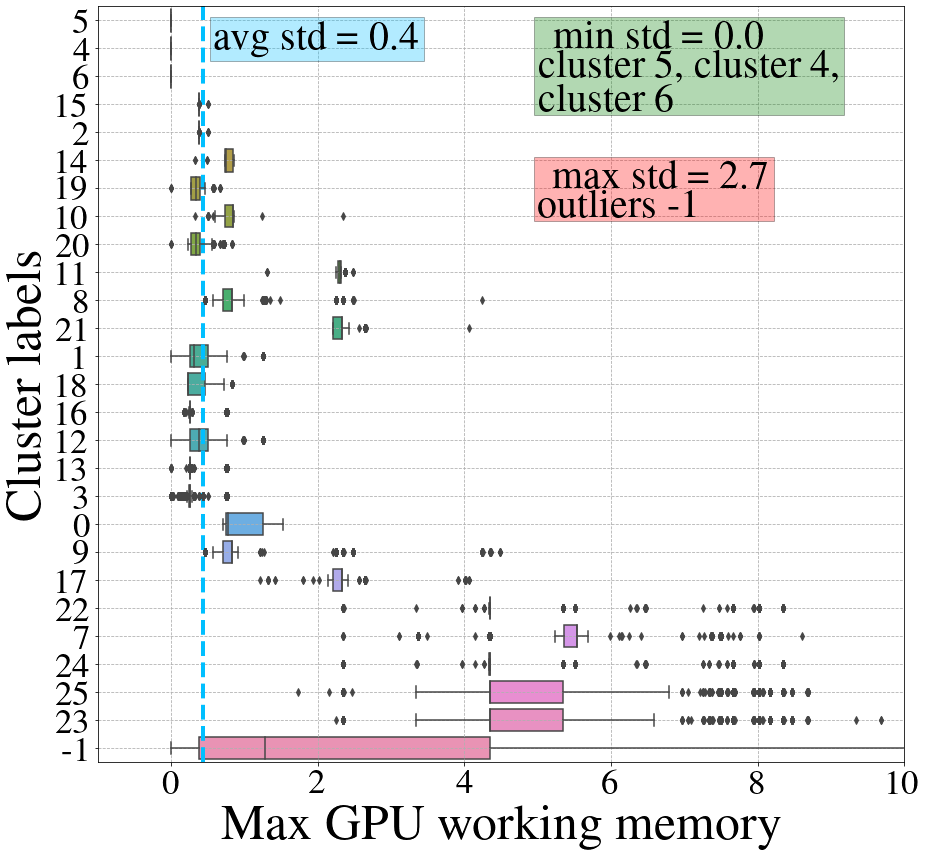

In [47]:
plt.figure(figsize=figsize)

df = pd.DataFrame(dict(max_gpu_wrk_mem=sampled_workload_data["max_gpu_wrk_mem"], clusters=[str(x) for x in hdbscan_clusterer.labels_]))
my_order = df.groupby(by=["clusters"])["max_gpu_wrk_mem"].std().sort_values(ascending=True).to_dict() #


plt.text(5, 1,
         r'min std = %.1f \\ cluster %s, cluster %s, \\ cluster %s' % (my_order[[x for x in my_order.keys()][0]], 
                                                                  [x for x in my_order.keys()][0],
                                                                 [x for x in my_order.keys()][1],
                                                                 [x for x in my_order.keys()][2]),
         bbox=dict(facecolor='green',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)

plt.text(5, 6,
         r'max std = %.1f \\ outliers %s' % (my_order[[x for x in my_order.keys()][-1]], [x for x in my_order.keys()][-1]),
         bbox=dict(facecolor='red',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)
 
    
plt.text(np.mean([e for e in my_order.values()]) + 0.15, 1,
         'avg std = %.1f' % (np.mean([e for e in my_order.values()])),
         bbox=dict(facecolor='deepskyblue',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)

plt.axvline(x=np.mean([e for e in my_order.values()]), color='deepskyblue', ls='--', lw=4)



#my_order = [str(x) for x in range(25, -2, -1)]
sns.boxplot(y='clusters', x='max_gpu_wrk_mem', data=df, order=my_order)

plt.xlabel('Max GPU working memory', fontsize=label_size)
plt.ylabel('Cluster labels', fontsize=label_size)
plt.xticks(fontsize=ticks_size)
plt.yticks(fontsize=ticks_size)

plt.grid(axis='both', linestyle='--')

plt.xlim((-1,10))

plt.tight_layout()
plt.savefig('Figures/NSDI_paper/HDBSCAN_boxplot_std_GpuMem.pdf', **figparams)

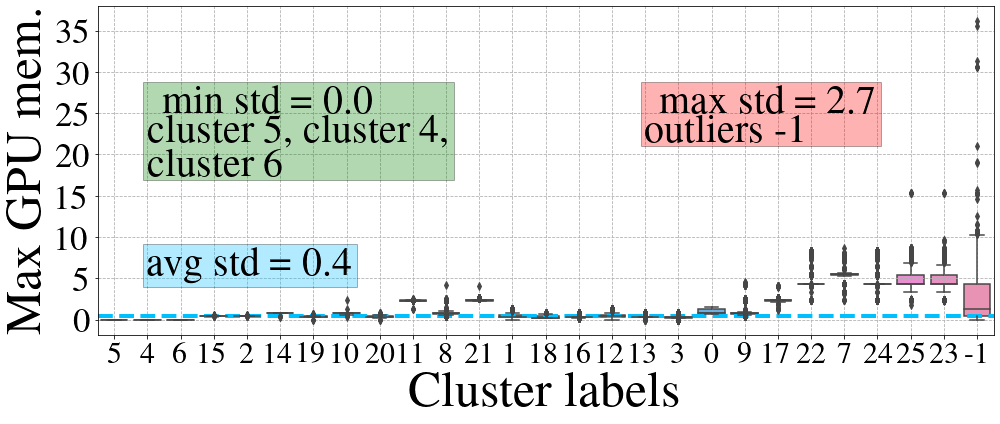

In [48]:
plt.figure(figsize=(14, 6))

df = pd.DataFrame(dict(max_gpu_wrk_mem=sampled_workload_data["max_gpu_wrk_mem"], clusters=[str(x) for x in hdbscan_clusterer.labels_]))
my_order = df.groupby(by=["clusters"])["max_gpu_wrk_mem"].std().sort_values(ascending=True).to_dict() #


plt.text(1, 25,
         r'min std = %.1f \\ cluster %s, cluster %s, \\ cluster %s' % (my_order[[x for x in my_order.keys()][0]], 
                                                                  [x for x in my_order.keys()][0],
                                                                 [x for x in my_order.keys()][1],
                                                                 [x for x in my_order.keys()][2]),
         bbox=dict(facecolor='green',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)

plt.text(16, 25,
         r'max std = %.1f \\ outliers %s' % (my_order[[x for x in my_order.keys()][-1]], [x for x in my_order.keys()][-1]),
         bbox=dict(facecolor='red',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)
 
    
plt.text(1, np.mean([e for e in my_order.values()]) + 5,
         'avg std = %.1f' % (np.mean([e for e in my_order.values()])),
         bbox=dict(facecolor='deepskyblue',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)

plt.axhline(y=np.mean([e for e in my_order.values()]), color='deepskyblue', ls='--', lw=4)



#my_order = [str(x) for x in range(25, -2, -1)]
sns.boxplot(x='clusters', y='max_gpu_wrk_mem', data=df, order=my_order)

plt.ylabel(r'Max GPU mem.', fontsize=label_size)
plt.xlabel('Cluster labels', fontsize=label_size)
plt.xticks(fontsize=ticks_size-5)
plt.yticks(fontsize=ticks_size)

plt.grid(axis='both', linestyle='--')

#plt.xlim((-1,10))

plt.tight_layout()
plt.savefig('Figures/NSDI_paper/HDBSCAN_boxplot_std_GpuMem_vertical.pdf', bbox_inches='tight')

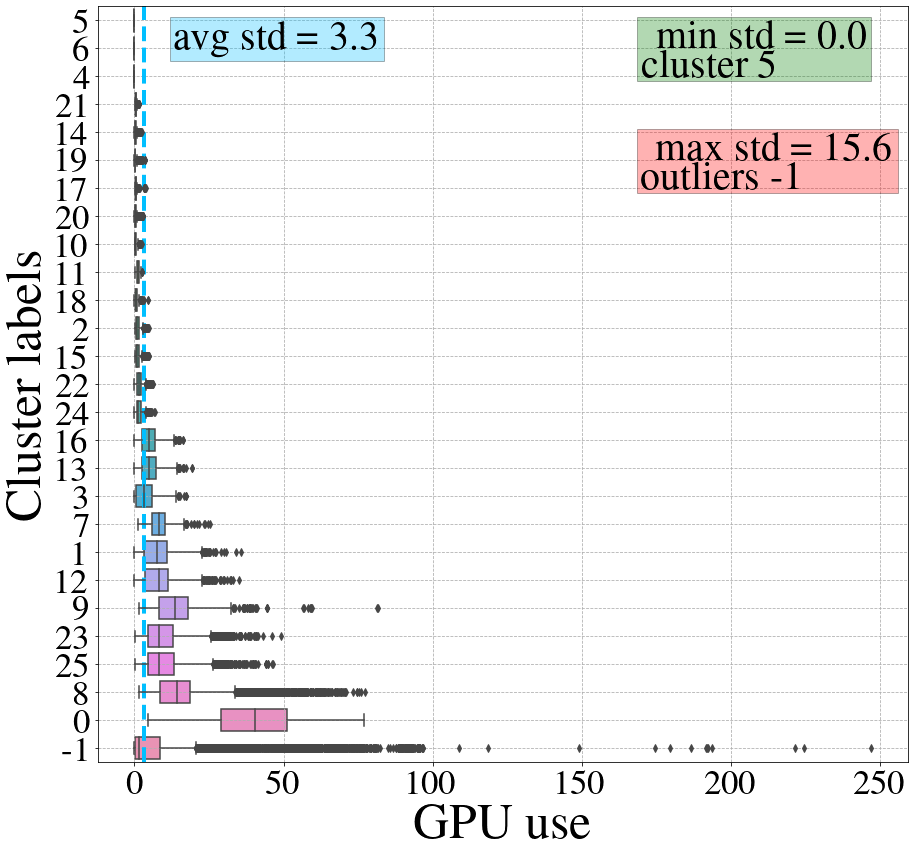

In [49]:
plt.figure(figsize=figsize)

df = pd.DataFrame(dict(gpu_wrk_util=sampled_workload_data["gpu_wrk_util"], clusters=[str(x) for x in hdbscan_clusterer.labels_]))
my_order = df.groupby(by=["clusters"])["gpu_wrk_util"].std().sort_values(ascending=True).to_dict() #

plt.text(170, 1,
         r'min std = %.1f \\ cluster %s' % (my_order[[x for x in my_order.keys()][0]], [x for x in my_order.keys()][0]),
         bbox=dict(facecolor='green',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)

plt.text(170, 5,
         r'max std = %.1f \\ outliers %s' % (my_order[[x for x in my_order.keys()][-1]], [x for x in my_order.keys()][-1]),
         bbox=dict(facecolor='red',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)
 
    
plt.text(np.mean([e for e in my_order.values()]) + 10, 1,
         'avg std = %.1f' % (np.mean([e for e in my_order.values()])),
         bbox=dict(facecolor='deepskyblue',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)

plt.axvline(x=np.mean([e for e in my_order.values()]), color='deepskyblue', ls='--', lw=4)


sns.boxplot(y='clusters', x='gpu_wrk_util', data=df, order=my_order)

plt.xlabel('GPU use', fontsize=label_size)
plt.ylabel('Cluster labels', fontsize=label_size)
plt.xticks(fontsize=ticks_size)
plt.yticks(fontsize=ticks_size)

plt.grid(axis='both', linestyle='--')

#my_order = [str(x) for x in range(25, -2, -1)]
#plt.xlim((-1,80_000))

plt.tight_layout()
plt.savefig('Figures/NSDI_paper/HDBSCAN_boxplot_std_GPUWorkUtil.pdf', **figparams)

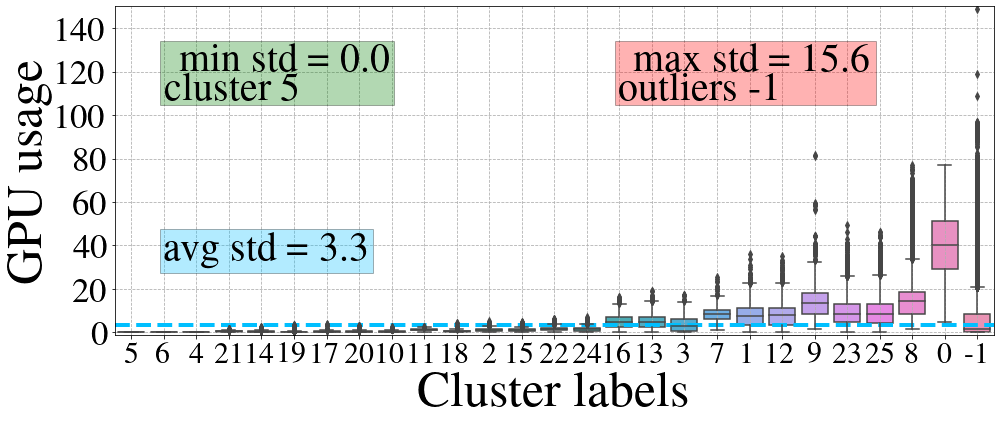

In [50]:
plt.figure(figsize=(14, 6))

df = pd.DataFrame(dict(gpu_wrk_util=sampled_workload_data["gpu_wrk_util"], clusters=[str(x) for x in hdbscan_clusterer.labels_]))
my_order = df.groupby(by=["clusters"])["gpu_wrk_util"].std().sort_values(ascending=True).to_dict() #

plt.text(1, 120,
         r'min std = %.1f \\ cluster %s' % (my_order[[x for x in my_order.keys()][0]], [x for x in my_order.keys()][0]),
         bbox=dict(facecolor='green',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)

plt.text(15, 120, 
         r'max std = %.1f \\ outliers %s' % (my_order[[x for x in my_order.keys()][-1]], [x for x in my_order.keys()][-1]),
         bbox=dict(facecolor='red',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)
 
    
plt.text( 1, np.mean([e for e in my_order.values()]) + 30,
         'avg std = %.1f' % (np.mean([e for e in my_order.values()])),
         bbox=dict(facecolor='deepskyblue',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)

plt.axhline(y=np.mean([e for e in my_order.values()]), color='deepskyblue', ls='--', lw=4)


sns.boxplot(x='clusters', y='gpu_wrk_util', data=df, order=my_order)

plt.ylabel('GPU usage', fontsize=label_size)
plt.xlabel('Cluster labels', fontsize=label_size)
plt.xticks(fontsize=ticks_size-5)
plt.yticks(fontsize=ticks_size)

plt.grid(axis='both', linestyle='--')

#my_order = [str(x) for x in range(25, -2, -1)]
plt.ylim((-1,150))

plt.tight_layout()
plt.savefig('Figures/NSDI_paper/HDBSCAN_boxplot_std_GPUWorkUtil_vertical.pdf', bbox_inches='tight')

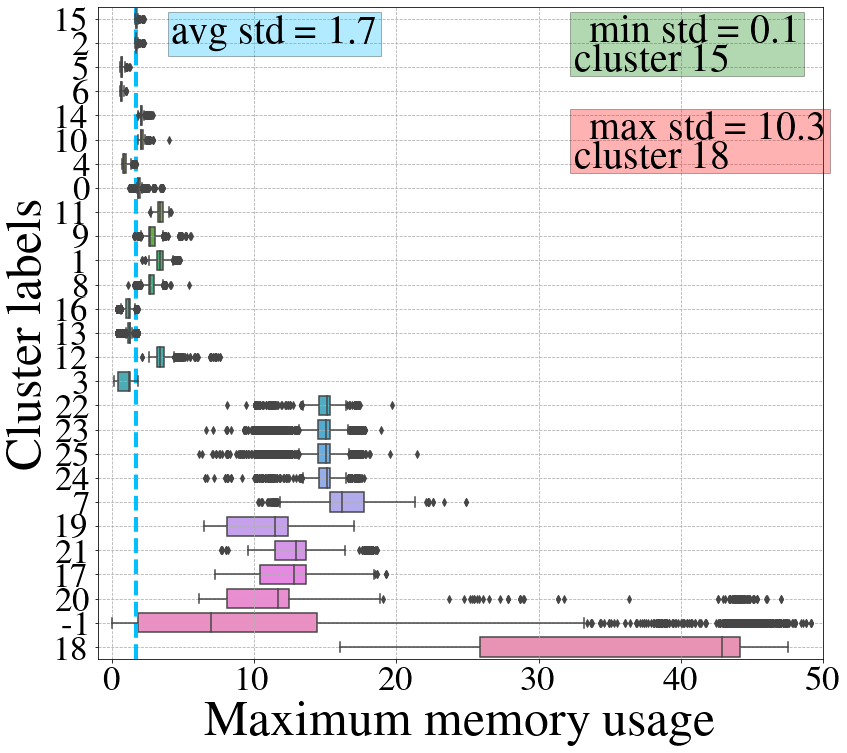

In [51]:
plt.figure(figsize=figsize)

df = pd.DataFrame(dict(max_mem=sampled_workload_data["max_mem"], clusters=[str(x) for x in hdbscan_clusterer.labels_]))
my_order = df.groupby(by=["clusters"])["max_mem"].std().sort_values(ascending=True).to_dict() #


plt.text(32.5, 1,
         r'min std = %.1f \\ cluster %s' % (my_order[[x for x in my_order.keys()][0]], [x for x in my_order.keys()][0]),
         bbox=dict(facecolor='green',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)

plt.text(32.5, 5,
         r'max std = %.1f \\ cluster %s' % (my_order[[x for x in my_order.keys()][-1]], [x for x in my_order.keys()][-1]),
         bbox=dict(facecolor='red',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)
 
    
plt.text(np.mean([e for e in my_order.values()]) + 2.5, 1,
         'avg std = %.1f' % (np.mean([e for e in my_order.values()])),
         bbox=dict(facecolor='deepskyblue',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)

plt.axvline(x=np.mean([e for e in my_order.values()]), color='deepskyblue', ls='--', lw=4)

#my_order = [str(x) for x in range(25, -2, -1)]
sns.boxplot(y='clusters', x='max_mem', data=df, order=my_order)

plt.xlabel('Maximum memory usage', fontsize=label_size)
plt.ylabel('Cluster labels', fontsize=label_size)
plt.xticks(fontsize=ticks_size)
plt.yticks(fontsize=ticks_size)

plt.grid(axis='both', linestyle='--')

plt.xlim((-1,50))

#plt.tight_layout()
plt.savefig('Figures/NSDI_paper/HDBSCAN_boxplot_std_MaxMem.pdf', bbox_inches='tight')

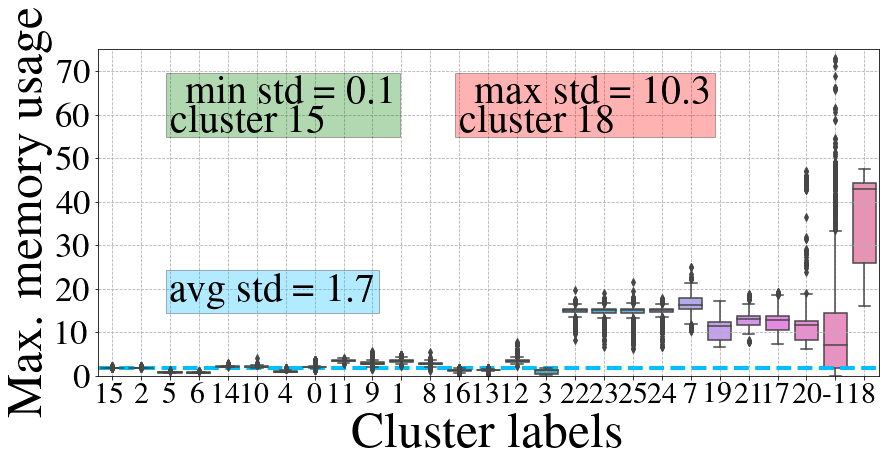

In [52]:
plt.figure(figsize=(14, 6))

df = pd.DataFrame(dict(max_mem=sampled_workload_data["max_mem"], clusters=[str(x) for x in hdbscan_clusterer.labels_]))
my_order = df.groupby(by=["clusters"])["max_mem"].std().sort_values(ascending=True).to_dict() #


plt.text(2, 62.5,
         r'min std = %.1f \\ cluster %s' % (my_order[[x for x in my_order.keys()][0]], [x for x in my_order.keys()][0]),
         bbox=dict(facecolor='green',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)

plt.text(12, 62.5,
         r'max std = %.1f \\ cluster %s' % (my_order[[x for x in my_order.keys()][-1]], [x for x in my_order.keys()][-1]),
         bbox=dict(facecolor='red',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)
 
    
plt.text(2, np.mean([e for e in my_order.values()]) + 15.5,
         'avg std = %.1f' % (np.mean([e for e in my_order.values()])),
         bbox=dict(facecolor='deepskyblue',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)

plt.axhline(y=np.mean([e for e in my_order.values()]), color='deepskyblue', ls='--', lw=4)

#my_order = [str(x) for x in range(25, -2, -1)]
sns.boxplot(x='clusters', y='max_mem', data=df, order=my_order)

plt.ylabel('Max. memory usage', fontsize=label_size)
plt.xlabel('Cluster labels', fontsize=label_size)
plt.xticks(fontsize=ticks_size-5)
plt.yticks(fontsize=ticks_size)

plt.grid(axis='both', linestyle='--')

plt.ylim((0,75))

#plt.tight_layout()
plt.savefig('Figures/NSDI_paper/HDBSCAN_boxplot_std_MaxMem_vertical.pdf', bbox_inches='tight')

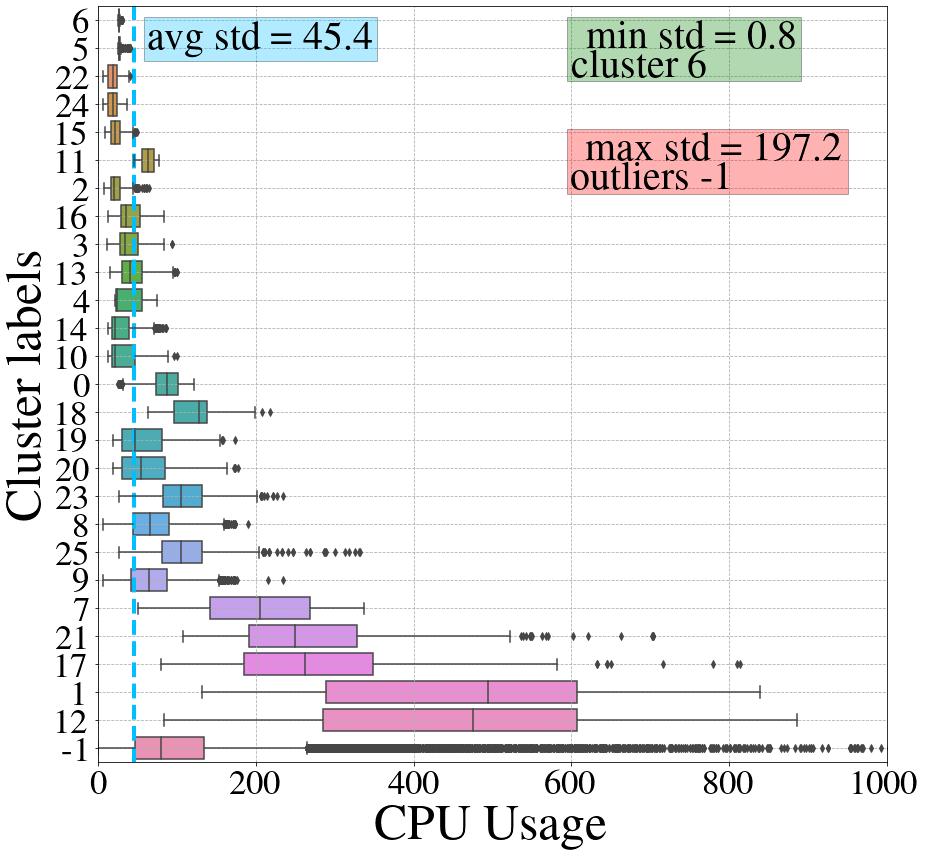

In [53]:
plt.figure(figsize=figsize)

df = pd.DataFrame(dict(cpu_usage=sampled_workload_data["cpu_usage"], clusters=[str(x) for x in hdbscan_clusterer.labels_]))
my_order = df.groupby(by=["clusters"])["cpu_usage"].std().sort_values(ascending=True).to_dict() #

plt.text(600, 1,
         r'min std = %.1f \\ cluster %s' % (my_order[[x for x in my_order.keys()][0]], [x for x in my_order.keys()][0]),
         bbox=dict(facecolor='green',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)

plt.text(600, 5,
         r'max std = %.1f \\ outliers %s' % (my_order[[x for x in my_order.keys()][-1]], [x for x in my_order.keys()][-1]),
         bbox=dict(facecolor='red',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)
 
    
plt.text(np.mean([e for e in my_order.values()]) + 17, 1,
         'avg std = %.1f' % (np.mean([e for e in my_order.values()])),
         bbox=dict(facecolor='deepskyblue',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)

plt.axvline(x=np.mean([e for e in my_order.values()]), color='deepskyblue', ls='--', lw=4)


sns.boxplot(y='clusters', x='cpu_usage', data=df, order=my_order)

plt.xlabel('CPU Usage', fontsize=label_size)
plt.ylabel('Cluster labels', fontsize=label_size)
plt.xticks(fontsize=ticks_size)
plt.yticks(fontsize=ticks_size)

plt.grid(axis='both', linestyle='--')

#my_order = [str(x) for x in range(25, -2, -1)]
plt.xlim((-1,1_000))

plt.tight_layout()
plt.savefig('Figures/NSDI_paper/HDBSCAN_boxplot_std_CPU.pdf', **figparams)

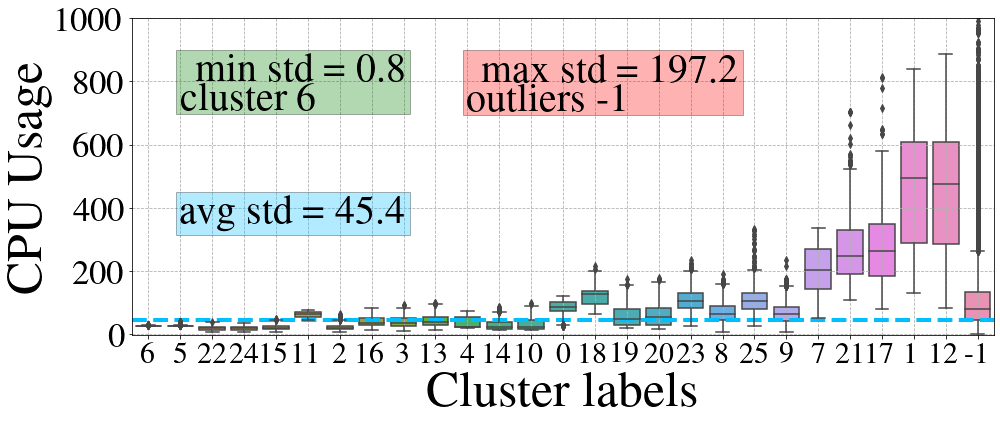

In [54]:
plt.figure(figsize=(14, 6))

df = pd.DataFrame(dict(cpu_usage=sampled_workload_data["cpu_usage"], clusters=[str(x) for x in hdbscan_clusterer.labels_]))
my_order = df.groupby(by=["clusters"])["cpu_usage"].std().sort_values(ascending=True).to_dict() #

plt.text(1, 800,
         r'min std = %.1f \\ cluster %s' % (my_order[[x for x in my_order.keys()][0]], [x for x in my_order.keys()][0]),
         bbox=dict(facecolor='green',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)

plt.text(10, 800,
         r'max std = %.1f \\ outliers %s' % (my_order[[x for x in my_order.keys()][-1]], [x for x in my_order.keys()][-1]),
         bbox=dict(facecolor='red',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)
 
    
plt.text(1, np.mean([e for e in my_order.values()]) + 307,
         'avg std = %.1f' % (np.mean([e for e in my_order.values()])),
         bbox=dict(facecolor='deepskyblue',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)

plt.axhline(y=np.mean([e for e in my_order.values()]), color='deepskyblue', ls='--', lw=4)
#

sns.boxplot(x='clusters', y='cpu_usage', data=df, order=my_order)

plt.ylabel('CPU Usage', fontsize=label_size)
plt.xlabel('Cluster labels', fontsize=label_size)
plt.xticks(fontsize=ticks_size-5)
plt.yticks(fontsize=ticks_size)

plt.grid(axis='both', linestyle='--')

#my_order = [str(x) for x in range(25, -2, -1)]
plt.ylim((-1,1_000))

plt.tight_layout()
plt.savefig('Figures/NSDI_paper/HDBSCAN_boxplot_std_CPU_vertical.pdf', **figparams)

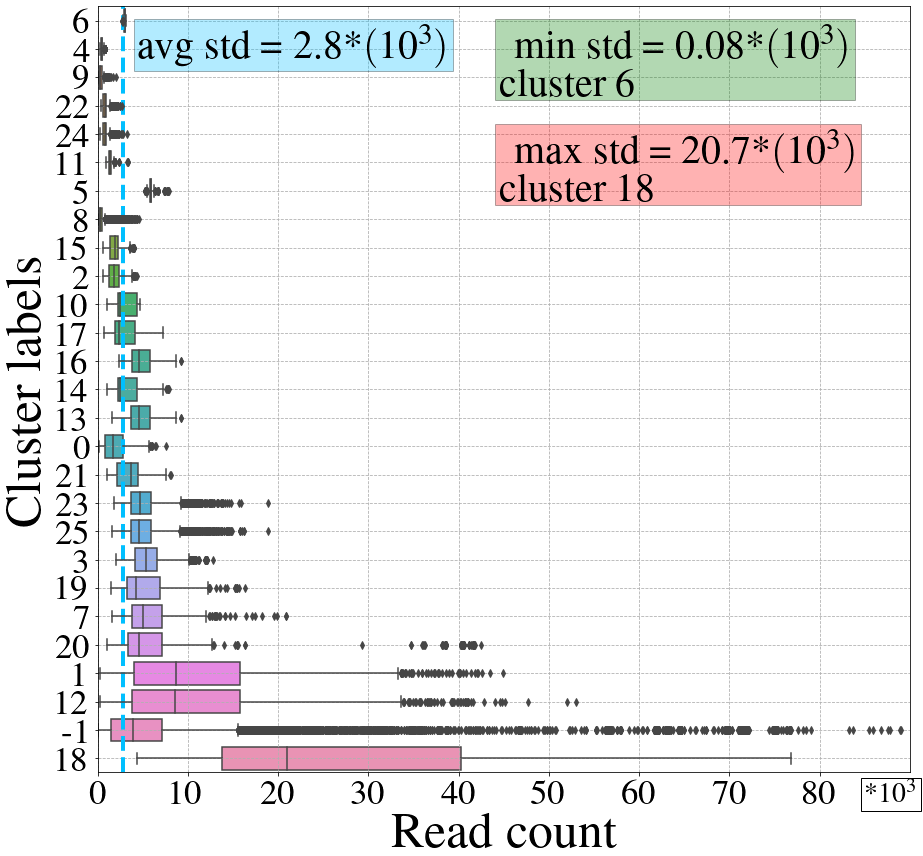

In [55]:
plt.figure(figsize=figsize)

df = pd.DataFrame(dict(read_count=sampled_workload_data["read_count"], clusters=[str(x) for x in hdbscan_clusterer.labels_]))
my_order = df.groupby(by=["clusters"])["read_count"].std().sort_values(ascending=True).to_dict() #

plt.text(44_500, 1.3,
         r'min std = %.2f*$(10^3)$\\ cluster %s' % (my_order[[x for x in my_order.keys()][0]] / 1_000, [x for x in my_order.keys()][0]),
         bbox=dict(facecolor='green',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)

plt.text(44_500, 5,
         r'max std = %.1f*$(10^3)$\\ cluster %s' % (my_order[[x for x in my_order.keys()][-1]] / 1_000, [x for x in my_order.keys()][-1]),
         bbox=dict(facecolor='red',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)
 
    
plt.text(np.mean([e for e in my_order.values()]) + 1600, 1.3,
         'avg std = %.1f*$(10^3)$' % (np.mean([e for e in my_order.values()]) / 1_000),
         bbox=dict(facecolor='deepskyblue',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)

plt.axvline(x=np.mean([e for e in my_order.values()]), color='deepskyblue', ls='--', lw=4)


sns.boxplot(y='clusters', x='read_count', data=df, order=my_order)

plt.xlim((-1,90_000))

#plt.xlabel(r'Read count', fontsize=label_size)
plt.xlabel(r'{\fontsize{50pt}{3em}\selectfont{}Read count }')

plt.ylabel('Cluster labels', fontsize=label_size)
plt.xticks(range(0, 90_000, 10_000), range(0, 90, 10), fontsize=ticks_size)
plt.yticks(fontsize=ticks_size)


plt.text(85_000, 27.5,
         r'*$10^3$',
          bbox=dict(facecolor='white',
           alpha=1),
         fontsize=(28))


plt.grid(axis='both', linestyle='--')

#my_order = [str(x) for x in range(25, -2, -1)]


plt.tight_layout()
plt.savefig('Figures/NSDI_paper/HDBSCAN_boxplot_std_readCount.pdf', **figparams)

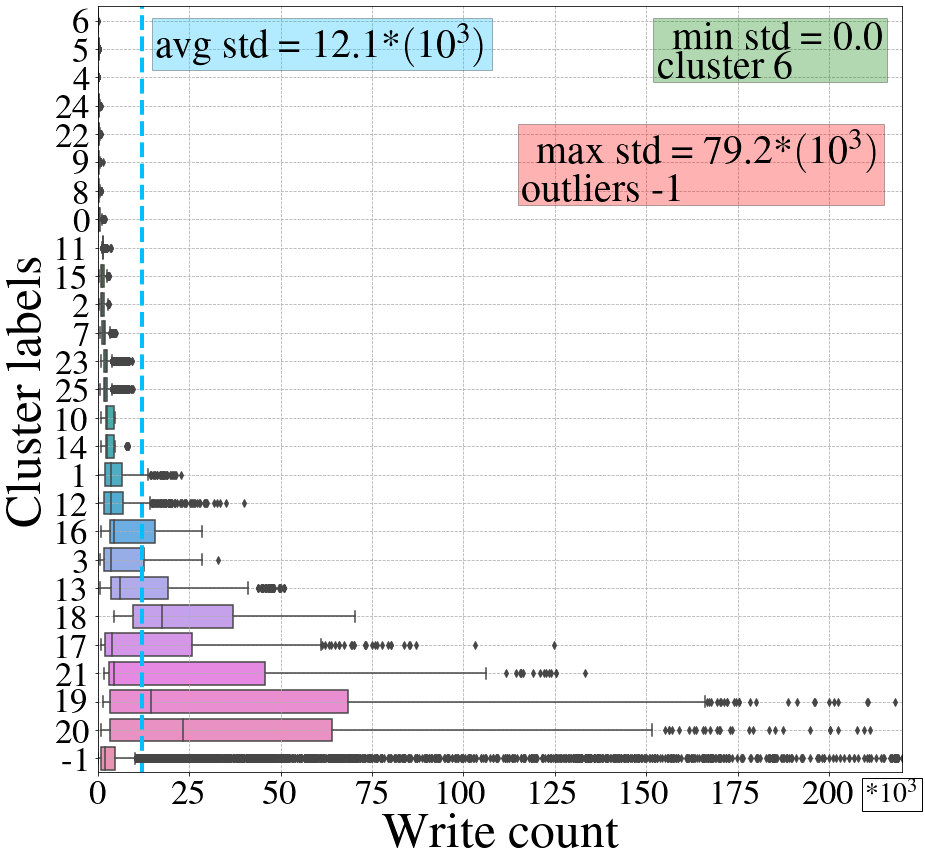

In [56]:
plt.figure(figsize=figsize)

df = pd.DataFrame(dict(write_count=sampled_workload_data["write_count"], clusters=[str(x) for x in hdbscan_clusterer.labels_]))
my_order = df.groupby(by=["clusters"])["write_count"].std().sort_values(ascending=True).to_dict() #

plt.text(153_000, 1,
         r'min std = %.1f \\ cluster %s' % (my_order[[x for x in my_order.keys()][0]] / 1000, [x for x in my_order.keys()][0]),
         bbox=dict(facecolor='green',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)

plt.text(116_000, 5,
         r'max std = %.1f*$(10^3)$ \\ outliers %s' % (my_order[[x for x in my_order.keys()][-1]] / 1_000, [x for x in my_order.keys()][-1]),
         bbox=dict(facecolor='red',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)
 
    
plt.text(np.mean([e for e in my_order.values()]) + 4_000, 1.25,
         'avg std = %.1f*$(10^3)$' % (np.mean([e for e in my_order.values()]) / 1_000),
         bbox=dict(facecolor='deepskyblue',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)

plt.axvline(x=np.mean([e for e in my_order.values()]), color='deepskyblue', ls='--', lw=4)


sns.boxplot(y='clusters', x='write_count', data=df, order=my_order)

plt.xlim((-1,220_000))

#plt.xlabel('Write count', fontsize=label_size)
plt.xlabel(r'{\fontsize{50pt}{3em}\selectfont{}Write count }')
plt.ylabel('Cluster labels', fontsize=label_size)
plt.xticks(range(0, 225_000, 25_000), range(0, 225, 25), fontsize=ticks_size)
plt.yticks(fontsize=ticks_size)

plt.grid(axis='both', linestyle='--')


plt.text(210_000, 27.5,
         r'*$10^3$',
          bbox=dict(facecolor='white',
           alpha=1),
         fontsize=(28))


#my_order = [str(x) for x in range(25, -2, -1)]

plt.tight_layout()
plt.savefig('Figures/NSDI_paper/HDBSCAN_boxplot_std_writeCount.pdf', **figparams)

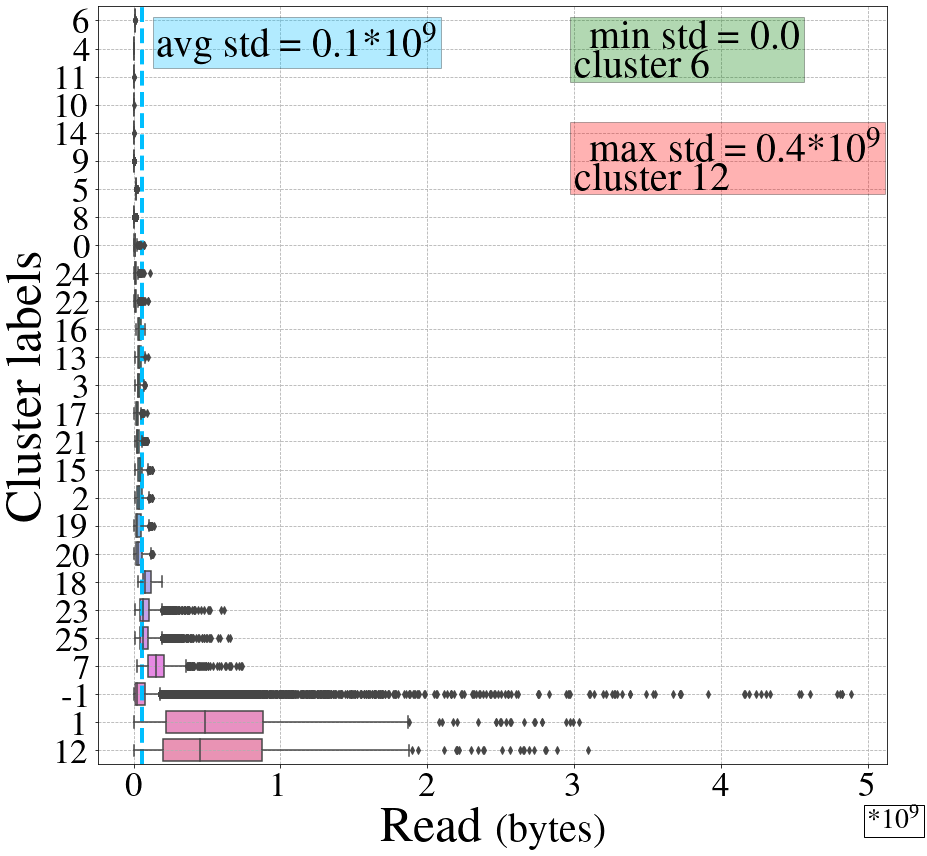

In [57]:
plt.figure(figsize=figsize)

df = pd.DataFrame(dict(read=sampled_workload_data["read"], clusters=[str(x) for x in hdbscan_clusterer.labels_]))
my_order = df.groupby(by=["clusters"])["read"].std().sort_values(ascending=True).to_dict() #

plt.text(3_000_000_000, 1,
         r'min std = %.1f \\ cluster %s' % (my_order[[x for x in my_order.keys()][0]] / 1_000_000_000, [x for x in my_order.keys()][0]),
         bbox=dict(facecolor='green',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)

plt.text(3_000_000_000, 5,
         r'max std = %.1f*$10^9$ \\ cluster %s' % (my_order[[x for x in my_order.keys()][-1]] / 1_000_000_000, [x for x in my_order.keys()][-1]),
         bbox=dict(facecolor='red',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)
 
    
plt.text(np.mean([e for e in my_order.values()]) + 100_000_000, 1.25,
         'avg std = %.1f*$10^9$' % (np.mean([e for e in my_order.values()]) / 1_000_000_000),
         bbox=dict(facecolor='deepskyblue',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)

plt.axvline(x=np.mean([e for e in my_order.values()]), color='deepskyblue', ls='--', lw=4)


sns.boxplot(y='clusters', x='read', data=df, order=my_order)

#plt.xlim((-1,220_000))

#plt.xlabel('Write count', fontsize=label_size)
plt.xlabel(r'{\fontsize{50pt}{3em}\selectfont{}Read }{\fontsize{40pt}{3em}\selectfont{}(bytes)')
plt.ylabel('Cluster labels', fontsize=label_size)
plt.xticks(fontsize=ticks_size)
plt.yticks(fontsize=ticks_size)

plt.grid(axis='both', linestyle='--')


plt.text(5_000_000_000, 28.75,
         r'*$10^9$',
          bbox=dict(facecolor='white',
           alpha=1),
         fontsize=(28))


#my_order = [str(x) for x in range(25, -2, -1)]

plt.tight_layout()
plt.savefig('Figures/NSDI_paper/HDBSCAN_boxplot_std_readBytes.pdf', **figparams)

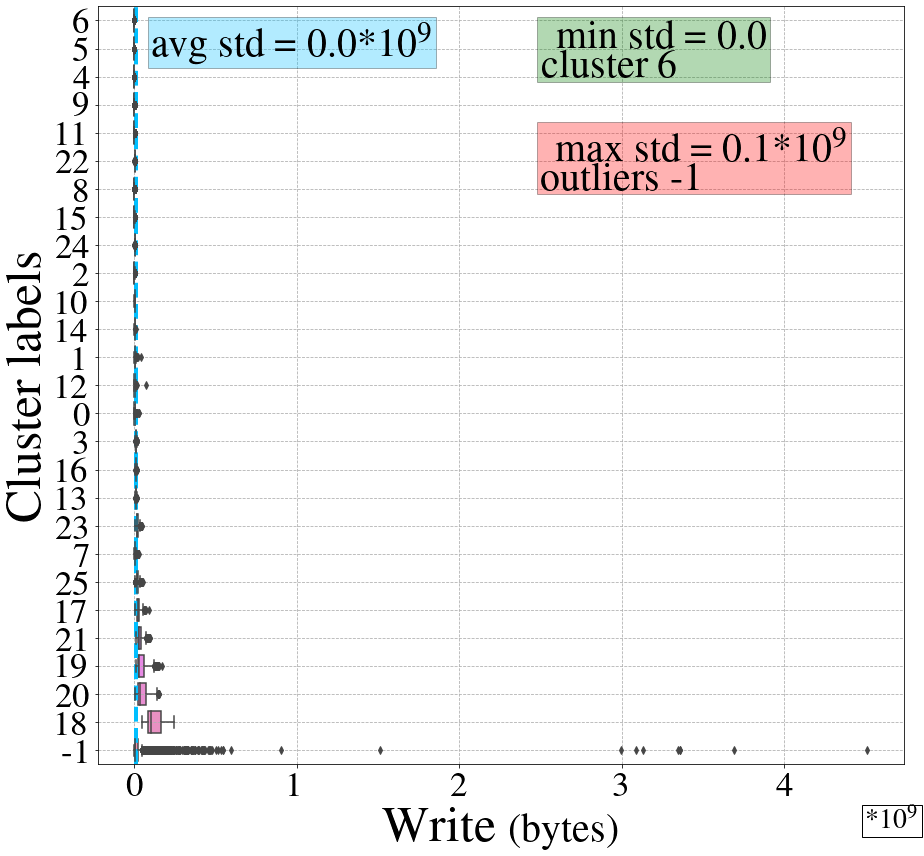

In [58]:
plt.figure(figsize=figsize)

df = pd.DataFrame(dict(write=sampled_workload_data["write"], clusters=[str(x) for x in hdbscan_clusterer.labels_]))
my_order = df.groupby(by=["clusters"])["write"].std().sort_values(ascending=True).to_dict() #

plt.text(2_500_000_000, 1,
         r'min std = %.1f \\ cluster %s' % (my_order[[x for x in my_order.keys()][0]] / 1_000_000_000, [x for x in my_order.keys()][0]),
         bbox=dict(facecolor='green',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)

plt.text(2_500_000_000, 5,
         r'max std = %.1f*$10^9$ \\ outliers %s' % (my_order[[x for x in my_order.keys()][-1]] / 1_000_000_000, [x for x in my_order.keys()][-1]),
         bbox=dict(facecolor='red',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)
 
    
plt.text(np.mean([e for e in my_order.values()]) + 100_000_000, 1.25,
         'avg std = %.1f*$10^9$' % (np.mean([e for e in my_order.values()]) / 1_000_000_000),
         bbox=dict(facecolor='deepskyblue',
                   alpha=textbox_alpha),
         fontsize=text_fontsize)

plt.axvline(x=np.mean([e for e in my_order.values()]), color='deepskyblue', ls='--', lw=4)


sns.boxplot(y='clusters', x='write', data=df, order=my_order)

plt.xlabel(r'{\fontsize{50pt}{3em}\selectfont{}Write }{\fontsize{40pt}{3em}\selectfont{}(bytes)')
plt.ylabel('Cluster labels', fontsize=label_size)
plt.xticks(fontsize=ticks_size)
plt.yticks(fontsize=ticks_size)

plt.grid(axis='both', linestyle='--')


plt.text(4_500_000_000, 28.75,
         r'*$10^9$',
          bbox=dict(facecolor='white',
           alpha=1),
         fontsize=(28))

plt.tight_layout()
plt.savefig('Figures/NSDI_paper/HDBSCAN_boxplot_std_writeBytes.pdf', **figparams)

### Extrapolate static metadata

In [59]:
categories_static_metadata = ['job_name', 'user', 'task_name', 'group', 'workload']

In [60]:
sampled_workload_metadata = sampled_workload_data[categories_static_metadata].astype("category")

#### Heatmap top k job names

In [61]:
if len(set(sampled_workload_metadata.job_name.values)) < 31:
    k = len(set(sampled_workload_metadata.job_name.values))
else:
    k = 10
topk_job_names = sampled_workload_metadata.job_name.value_counts(ascending=False)[:k].to_dict()

In [62]:
topk_job_names_values = []

for key in topk_job_names:
    job_name_values = []
    total_val = topk_job_names[key]
    
    where_jobname = sampled_workload_metadata.job_name == key
    for i in range(-1, 26):
        job_name_values.append(np.count_nonzero(hdbscan_clusterer.labels_[where_jobname] == i) / topk_job_names[key] * 100)
    topk_job_names_values.append(job_name_values)
topk_job_names_values = np.array(topk_job_names_values)
topk_job_names_values.shape

topk_job_names_df = pd.DataFrame(topk_job_names_values, columns=list(range(-1, 26)), index=topk_job_names)
topk_job_names_df

,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
94b340f2cdedf37303d41bf2,0.000000,0.0,0.0,0.0,0.000000,0.0,68.372093,31.627907,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9049a185495a4b2f2c389edb,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,49.203540,50.796460,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51f35b0aefdec65a7de17fe0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,48.694030,51.305970,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d864900a2d0335de12b903dc,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,49.338374,50.661626,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7c24b6c4e4668737e8b96e3a,54.671968,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,45.328032,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
446cd4921e0f00ab5ce1c2ea,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,50.597610,49.402390,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c4ffba111aaae53ff991210d,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,51.515152,48.484848,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
e9eb26e81f1959c887370292,0.210970,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,49.367089,50.421941,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6fe364dc050a0e4f51558a63,0.431034,0.0,0.0,0.0,32.974138,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,33.405172,0.0,0.0,33.189655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76aad33d9c0816d4739523a9,0.434783,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,51.086957,48.478261,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


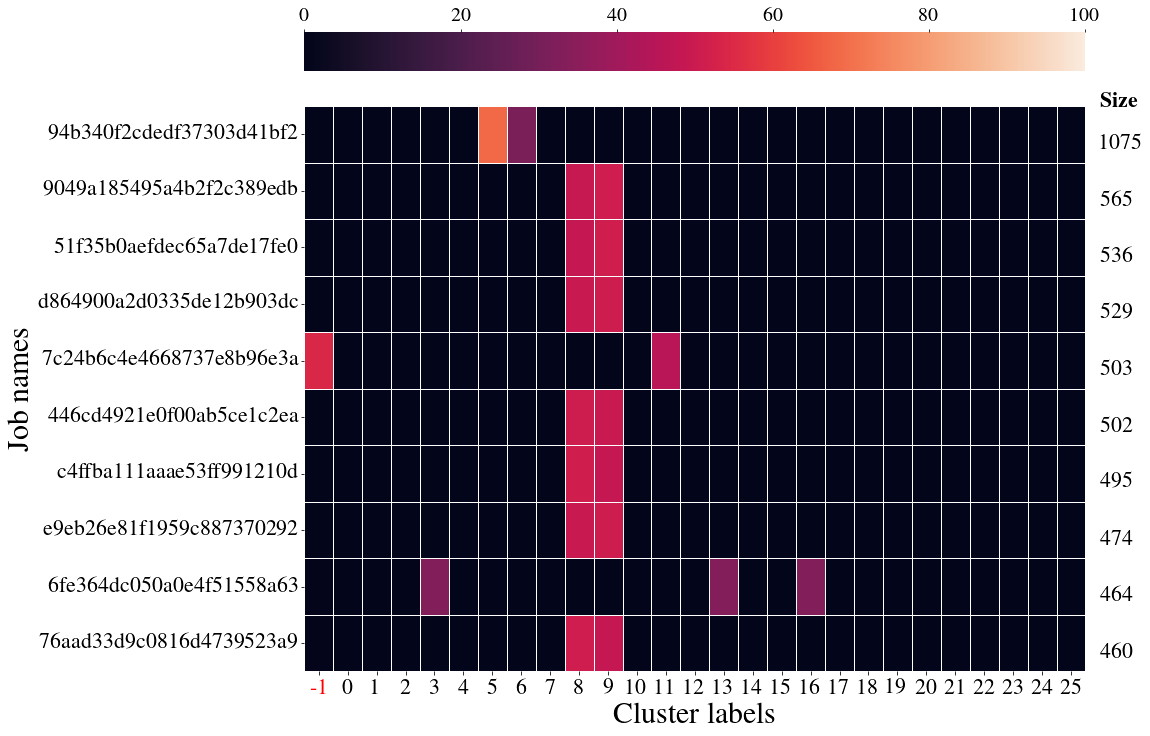

In [63]:
fig, ax = plt.subplots(figsize=(14, 13))
sns.heatmap(topk_job_names_df, linewidth=1, linecolor='w',  cbar_kws = dict(use_gridspec=False,location="top"), vmin=0, vmax=100, ax=ax)
ax.tick_params(axis='both', labelsize=22)

cbar = ax.collections[0].colorbar

cbar.ax.tick_params(labelsize=20)

ax.set_xlabel('Cluster labels', fontsize=30)
ax.set_ylabel('Job names', fontsize=30)

my_colors = ['r'] + ['k']*25

for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)


plt.text(27.5, 0,
         r'\textbf{Size}',
         fontsize=22)

for i, key in enumerate(topk_job_names.keys()):
    plt.text(27.5, i+0.75,
             topk_job_names[key],
             fontsize=22)
    
#plt.tight_layout()
plt.savefig('Figures/NSDI_paper/HDBSCAN_heatmap_jobnames.pdf', format='pdf', bbox_inches='tight')

#### Heatmap top k task_names

In [64]:
if len(set(sampled_workload_metadata.task_name.values)) < 31:
    k = len(set(sampled_workload_metadata.task_name.values))
else:
    k = 10

topk_task_names = sampled_workload_metadata.task_name.value_counts(ascending=False)[:k].to_dict()

In [65]:
topk_task_names

{'worker': 50125,
 'ps': 46116,
 'evaluator': 3495,
 'PyTorchWorker': 193,
 'tensorflow': 67,
 'OssToVolumeWorker': 4,
 'OpenmpiTracker': 1}

In [66]:
topk_task_names_values = []

for key in topk_task_names:
    task_name_values = []
    total_val = topk_task_names[key]
    
    where_taskname = sampled_workload_metadata.task_name == key
    for i in range(-1, 26):
        task_name_values.append(np.count_nonzero(hdbscan_clusterer.labels_[where_taskname] == i) / topk_task_names[key] * 100)
    topk_task_names_values.append(task_name_values)
topk_task_names_values = np.array(topk_task_names_values)
topk_task_names_values.shape

topk_task_names_df = pd.DataFrame(topk_task_names_values, columns=list(range(-1, 26)), index=topk_task_names)
topk_task_names_df

,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
worker,22.890773,4.189526,0.000000,0.00000,0.000000,1.430424,1.466334,0.678304,1.470324,24.981546,0.000000,0.000000,0.00000,10.974564,0.007980,1.368579,1.550125,3.876309,1.131172,1.167082,4.133666,0.000000,0.000000,3.772569,14.910723,0.000000,0.000000
ps,25.268887,0.000000,12.470726,1.81282,6.598578,0.000000,0.000000,0.000000,0.000000,0.000000,25.179981,1.405152,0.65487,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.614451,0.856536,0.000000,0.000000,4.323879,16.814121
evaluator,34.678112,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,65.321888,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PyTorchWorker,100.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
tensorflow,98.507463,1.492537,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OssToVolumeWorker,100.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OpenmpiTracker,100.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [67]:
np.count_nonzero(topk_task_names_df[[x for x in range(0, 26)]][topk_task_names_df.index == 'ps'].values != 0.0)

10

In [68]:
list(topk_task_names.keys())

['worker',
 'ps',
 'evaluator',
 'PyTorchWorker',
 'tensorflow',
 'OssToVolumeWorker',
 'OpenmpiTracker']

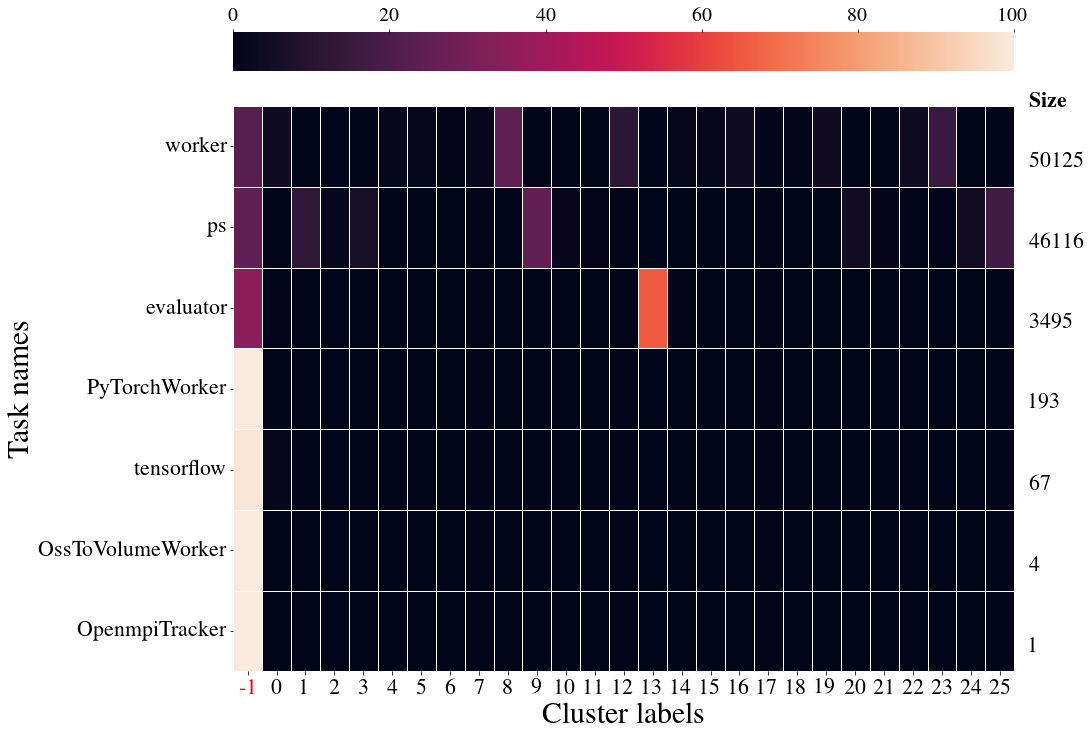

In [69]:
fig, ax = plt.subplots(figsize=(14, 13))
sns.heatmap(topk_task_names_df, linewidth=1, linecolor='w',  cbar_kws = dict(use_gridspec=False,location="top"), vmin=0, vmax=100, ax=ax)
ax.tick_params(axis='both', labelsize=22)

cbar = ax.collections[0].colorbar

cbar.ax.tick_params(labelsize=20)

ax.set_xlabel('Cluster labels', fontsize=30)
ax.set_ylabel('Task names', fontsize=30)

ax.set_yticklabels(list(topk_task_names.keys()),rotation='0', va='center')

my_colors = ['r'] + ['k']*25

for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)


plt.text(27.5, 0,
         r'\textbf{Size}',
         fontsize=22)

for i, key in enumerate(topk_task_names.keys()):
    plt.text(27.5, i+0.75,
             topk_task_names[key],
             fontsize=22)
    
#plt.tight_layout()
plt.savefig('Figures/NSDI_paper/HDBSCAN_heatmap_tasknames.pdf', format='pdf', bbox_inches='tight')

#### Heatmap top k workload

In [70]:
if len(set(sampled_workload_metadata.workload.values)) < 31:
    k = len(set(sampled_workload_metadata.workload.values))
else:
    k = 30

topk_workload_names = sampled_workload_metadata.workload.value_counts(ascending=False)[:k].to_dict()

In [71]:
topk_workload_names

{'bert': 29818,
 'inception': 29385,
 'ctr': 24881,
 'graphlearn': 13323,
 'rl': 2316,
 'resnet': 166,
 'xlnet': 43,
 'nmt': 37,
 'vgg': 32}

In [72]:
topk_workload_names_values = []

for key in topk_workload_names:
    workload_name_values = []
    total_val = topk_workload_names[key]
    
    where_workloadname = sampled_workload_metadata.workload == key
    for i in range(-1, 26):
        workload_name_values.append(np.count_nonzero(hdbscan_clusterer.labels_[where_workloadname] == i) / topk_workload_names[key] * 100)
    topk_workload_names_values.append(workload_name_values)
topk_workload_names_values = np.array(topk_workload_names_values)
topk_workload_names_values.shape

topk_workload_names_df = pd.DataFrame(topk_workload_names_values, columns=list(range(-1, 26)), index=topk_workload_names)
topk_workload_names_df

,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
bert,12.043061,7.04608,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.994768,38.916091,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
inception,32.448528,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.508082,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.435256,25.434746,6.785775,26.387613
ctr,19.062739,0.00000,23.114023,3.359994,12.230216,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.10924,9.191753,0.00000,3.122865,7.809172,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
graphlearn,44.577047,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007506,4.863769,2.266757,0.00000,0.000000,5.14899,0.000000,0.000000,4.255798,4.390903,15.552053,15.972379,2.964798,0.000000,0.000000,0.000000,0.000000
rl,22.625216,0.00000,0.000000,0.000000,0.000000,30.958549,31.735751,14.680484,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
resnet,100.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
xlnet,83.720930,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.279070,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
nmt,100.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
vgg,100.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


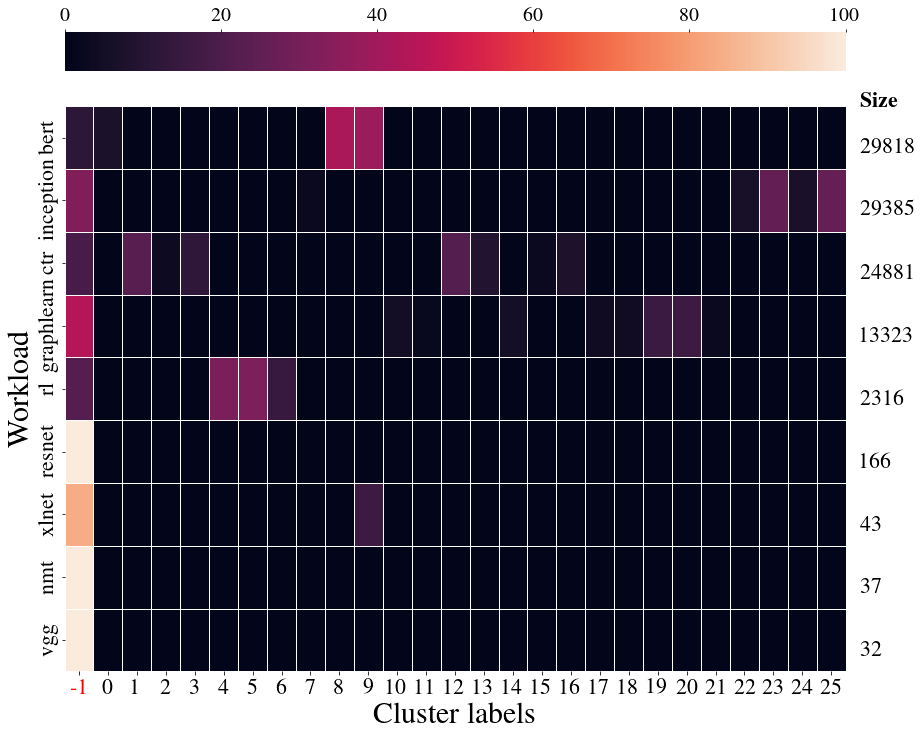

In [73]:
fig, ax = plt.subplots(figsize=(14, 13))
sns.heatmap(topk_workload_names_df, linewidth=1, linecolor='w',  cbar_kws = dict(use_gridspec=False,location="top"),vmin=0, vmax=100, ax=ax)
ax.tick_params(axis='both', labelsize=22)

cbar = ax.collections[0].colorbar

cbar.ax.tick_params(labelsize=20)

ax.set_xlabel('Cluster labels', fontsize=30)
ax.set_ylabel('Workload', fontsize=30)

my_colors = ['r'] + ['k']*25

for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)

plt.text(27.5, 0,
         r'\textbf{Size}',
         fontsize=22)

for i, key in enumerate(topk_workload_names.keys()):
    plt.text(27.5, i+0.75,
             topk_workload_names[key],
             fontsize=22)
    
#plt.tight_layout()
plt.savefig('Figures/NSDI_paper/HDBSCAN_heatmap_workload.pdf', format='pdf', bbox_inches='tight')

#### Heatmap top k group

In [74]:
if len(set(sampled_workload_metadata.group.values)) < 31:
    k = len(set(sampled_workload_metadata.group.values))
else:
    k = 10

topk_group = sampled_workload_metadata.group.value_counts(ascending=False)[:k].to_dict()

In [75]:
topk_group

{'02a6709662bff12fea88270e3eb1231d': 14925,
 '4ac7f9c48a6913dfa81169f7d6a150fa': 7948,
 'b27d953052e44998ee2fc7d1060f8371': 1777,
 '46de427b3b8cb620792fa8ca56fd8c06': 1381,
 'e249e7ad3c89403a7e73ec9be36a5e49': 1075,
 '943107e34f0d22d9ace411b9a1431912': 718,
 'cbb126576dcd238a8f70db115f9e48ab': 564,
 '382684c9b22508232f23ce59d0dc1f6d': 561,
 '2e773c917703943db13667bcf046e5ff': 534,
 '509b92a5f6c3086b1941fbf35ba16249': 530}

In [76]:
topk_group_values = []

for key in topk_group:
    group_values = []
    total_val = topk_group[key]
    
    where_group = sampled_workload_metadata.group == key
    for i in range(-1, 26):
        group_values.append(np.count_nonzero(hdbscan_clusterer.labels_[where_group] == i) / topk_group[key] * 100)
    topk_group_values.append(group_values)
topk_group_names_values = np.array(topk_group_values)

topk_group_df = pd.DataFrame(topk_group_values, columns=list(range(-1, 26)), index=topk_group)
topk_group_df

,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
02a6709662bff12fea88270e3eb1231d,0.154104,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,49.989950,49.855946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
4ac7f9c48a6913dfa81169f7d6a150fa,0.075491,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,50.805234,49.119275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
b27d953052e44998ee2fc7d1060f8371,1.350591,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,49.521666,49.127743,0.0,0.0,0.000000,0.0,0.000000
46de427b3b8cb620792fa8ca56fd8c06,98.624185,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,1.375815
e249e7ad3c89403a7e73ec9be36a5e49,0.000000,0.0,0.0,0.0,0.0,0.000000,68.372093,31.627907,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
943107e34f0d22d9ace411b9a1431912,0.139276,0.0,0.0,0.0,0.0,99.860724,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
cbb126576dcd238a8f70db115f9e48ab,54.964539,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.134752,0.000000,3.900709,0.0,0.0,0.000000,0.0,0.000000
382684c9b22508232f23ce59d0dc1f6d,98.752228,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.178253,0.0,1.069519
2e773c917703943db13667bcf046e5ff,70.599251,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,13.108614,0.0,16.292135
509b92a5f6c3086b1941fbf35ba16249,98.679245,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1.320755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000


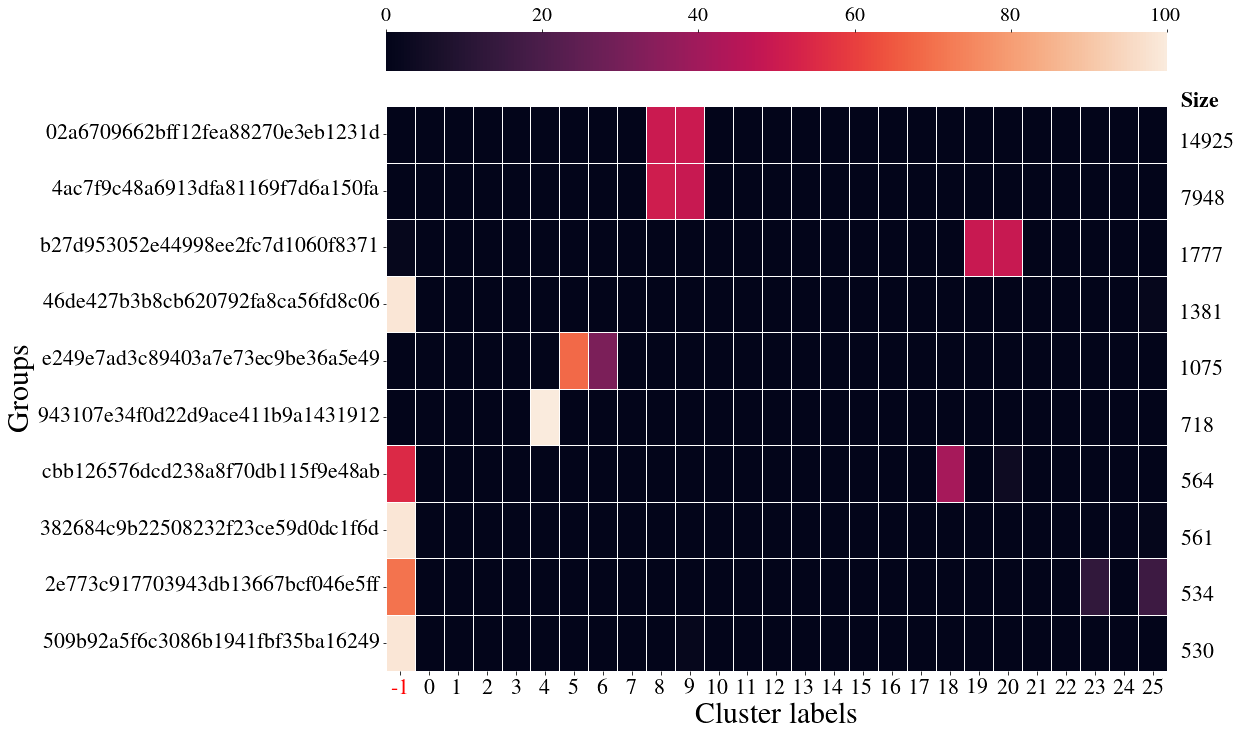

In [77]:
fig, ax = plt.subplots(figsize=(14, 13))
sns.heatmap(topk_group_df, linewidth=1, linecolor='w',  cbar_kws = dict(use_gridspec=False,location="top"), vmin=0, vmax=100, ax=ax)
ax.tick_params(axis='both', labelsize=22)

cbar = ax.collections[0].colorbar

cbar.ax.tick_params(labelsize=20)

ax.set_xlabel('Cluster labels', fontsize=30)
ax.set_ylabel('Groups', fontsize=30)

ax.set_yticklabels(list(topk_group.keys()),rotation='0', va='center')

my_colors = ['r'] + ['k']*25

for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)


plt.text(27.5, 0,
         r'\textbf{Size}',
         fontsize=22)

for i, key in enumerate(topk_group.keys()):
    plt.text(27.5, i+0.75,
             topk_group[key],
             fontsize=22)

plt.savefig('Figures/NSDI_paper/HDBSCAN_heatmap_groups.pdf', format='pdf', bbox_inches='tight')

#### Heatmap top k users

In [78]:
if len(set(sampled_workload_metadata.user.values)) < 31:
    k = len(set(sampled_workload_metadata.user.values))
else:
    k = 10

topk_user = sampled_workload_metadata.user.value_counts(ascending=False)[:k].to_dict()

In [79]:
topk_user

{'b3bfe9b79bb5': 27531,
 '2cbd33b08024': 22873,
 'd4d51aca8806': 17288,
 '50d7d4393650': 10513,
 '5b1345f03aa1': 5515,
 '5f4cb64dc693': 4137,
 '302aa475597b': 2316,
 '262fbc8b0c98': 1845,
 'c2a3a3121170': 899,
 'bbd5a1434ac7': 642}

In [80]:
topk_user_values = []

for key in topk_user:
    user_values = []
    total_val = topk_user[key]
    
    where_user = sampled_workload_metadata.user == key
    for i in range(-1, 26):
        user_values.append(np.count_nonzero(hdbscan_clusterer.labels_[where_user] == i) / topk_user[key] * 100)
    topk_user_values.append(user_values)
topk_user_names_values = np.array(topk_user_values)

topk_user_df = pd.DataFrame(topk_user_values, columns=list(range(-1, 26)), index=topk_user)
topk_user_df

,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
b3bfe9b79bb5,25.262431,0.116233,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.305111,0.544840,0.003632,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,3.196397,3.170971,0.000000,6.737859,26.159602,7.068396,27.434528
2cbd33b08024,0.126787,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.273248,49.599965,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
d4d51aca8806,17.567099,9.683017,31.605738,0.000000,3.736696,0.000000,0.000000,0.000000,0.000000,5.015039,0.000000,0.000000,0.0,30.229061,0.023137,0.000000,0.000000,0.00000,0.000000,1.717955,0.000000,0.422258,0.000000,0.000000,0.000000,0.000000,0.000000
50d7d4393650,21.687435,0.000000,0.000000,7.952059,22.800342,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,21.687435,0.000000,7.390849,18.48188,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5b1345f03aa1,48.449683,0.036265,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.024479,0.0,0.000000,0.000000,11.912965,0.000000,0.00000,10.281052,5.222121,2.629193,3.572076,6.872167,0.000000,0.000000,0.000000,0.000000
5f4cb64dc693,79.719604,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.307227,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.973169,0.000000,0.000000
302aa475597b,22.625216,0.000000,0.000000,0.000000,0.000000,30.958549,31.735751,14.680484,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
262fbc8b0c98,3.089431,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,50.081301,46.829268,0.000000,0.000000,0.000000,0.000000,0.000000
c2a3a3121170,63.181313,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,3.559511,12.235818,5.005562,16.017798
bbd5a1434ac7,13.084112,0.000000,44.236760,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,42.679128,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


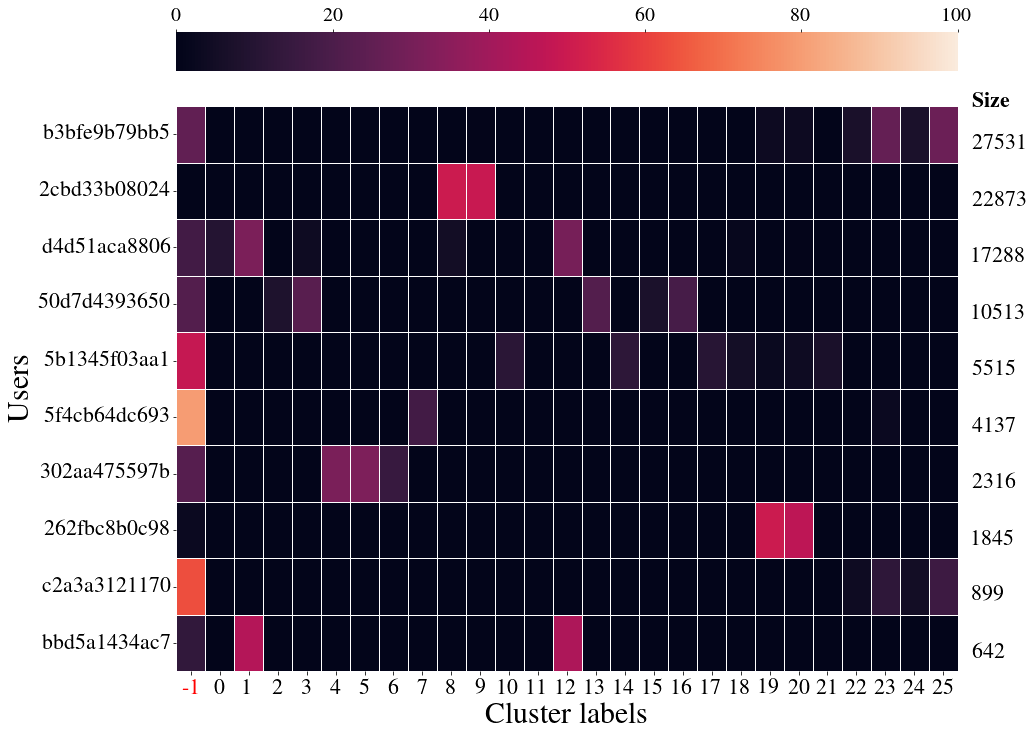

In [81]:
fig, ax = plt.subplots(figsize=(14, 13))
sns.heatmap(topk_user_df, linewidth=1, linecolor='w',  cbar_kws = dict(use_gridspec=False,location="top"), vmin=0, vmax=100, ax=ax)
ax.tick_params(axis='both', labelsize=22)

cbar = ax.collections[0].colorbar

cbar.ax.tick_params(labelsize=20)

ax.set_xlabel('Cluster labels', fontsize=30)
ax.set_ylabel('Users', fontsize=30)

ax.set_yticklabels(list(topk_user.keys()),rotation='0', va='center')

my_colors = ['r'] + ['k']*25

for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), my_colors):
    ticklabel.set_color(tickcolor)


plt.text(27.5, 0,
         r'\textbf{Size}',
         fontsize=22)

for i, key in enumerate(topk_user.keys()):
    plt.text(27.5, i+0.75,
             topk_user[key],
             fontsize=22)
    
#plt.tight_layout()
plt.savefig('Figures/NSDI_paper/HDBSCAN_heatmap_users.pdf', format='pdf', bbox_inches='tight')

## Classification

### Prepare data

#### Dummies

In [82]:
# sampled_workload_metadata_dummies = pd.get_dummies(sampled_workload_metadata, prefix=categories_static_metadata)

# hdbscan_clustered_metadata_cats = sampled_workload_metadata_dummies.values[mask.astype(bool)]

#### OneHotEncoder

In [83]:
sampled_workload_metadata.values[mask.astype(bool)].shape

(75398, 5)

In [157]:
onehot_enc = OneHotEncoder(sparse=True, handle_unknown='ignore').fit(sampled_workload_metadata)
sampled_onehotencoded_data = onehot_enc.transform(sampled_workload_metadata.values[mask.astype(bool)])
onehot_encoded_features = onehot_enc.get_feature_names_out(sampled_workload_metadata.columns)
onehot_encoded_features

X does not have valid feature names, but OneHotEncoder was fitted with feature names


array(['job_name_00007e24e5fedde13a7cba0d',
       'job_name_00013c59e5c6aa98afe39871',
       'job_name_0001a51716a714a1159660cf', ..., 'workload_rl',
       'workload_vgg', 'workload_xlnet'], dtype=object)

In [85]:
sampled_onehotencoded_data

<75398x21547 sparse matrix of type '<class 'numpy.float64'>'
	with 376990 stored elements in Compressed Sparse Row format>

### XGBoost

In [86]:
sampled_onehotencoded_data.shape

(75398, 21547)

In [87]:
X_train_csr, X_test_csr, y_train, y_test = train_test_split(sampled_onehotencoded_data, hdbscan_notnoise_labels, test_size=0.20, random_state=5)

In [88]:
(X_train_csr.shape, X_test_csr.shape)

((60318, 21547), (15080, 21547))

In [89]:
sampled_workload_data[mask.astype(bool)].shape

(75398, 29)

In [90]:
X_train_orig, X_test_orig, _, _ = train_test_split(sampled_workload_data[mask.astype(bool)], hdbscan_notnoise_labels, test_size=0.20, random_state=5)

In [91]:
(X_train_orig.shape, X_test_orig.shape)

((60318, 29), (15080, 29))

In [92]:
X_train_csr

<60318x21547 sparse matrix of type '<class 'numpy.float64'>'
	with 301590 stored elements in Compressed Sparse Row format>

In [93]:
##X_train_dask = dask.array.from_array(X_train_csr)

##X_train_dask

##int(np.ceil(len(y_train) / 108))

##y_train_dask = dask.array.from_array(y_train, chunks=int(np.ceil(len(y_train) / 108)))

##y_train_dask

In [94]:
##cluster = dask.distributed.LocalCluster()
##client = dask.distributed.Client(cluster)

In [95]:
##dtrain = xgb.dask.DaskDMatrix(client, X_train_dask, y_train_dask)

In [96]:
model = xgb.dask.XGBClassifier()

In [97]:
model.fit(X_train_csr, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [98]:
y_pred = model.predict(X_test_csr) 

predictions = [round(value) for value in y_pred]

In [99]:
proba = model.predict_proba(X_test_csr)

In [100]:
accuracy = accuracy_score(y_test, predictions) 

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.19%


In [101]:
model.get_booster().feature_names = list(onehot_encoded_features)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

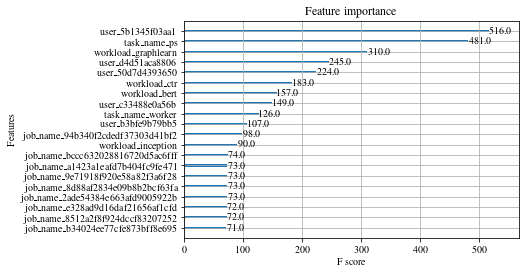

In [102]:
plot_importance(model, max_num_features=20)

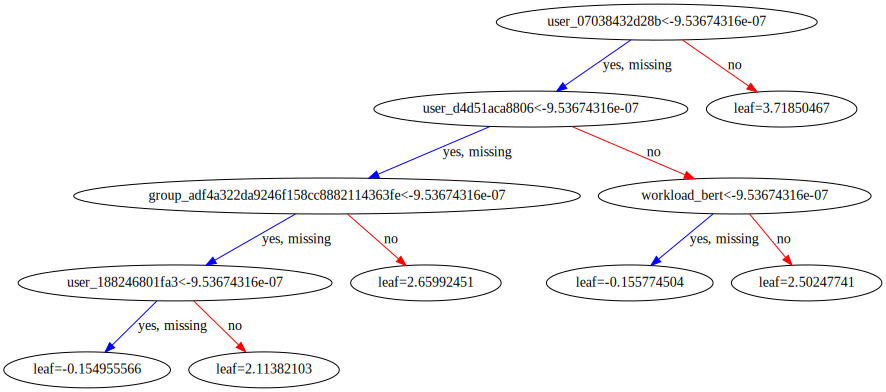

In [103]:
from xgboost import to_graphviz

to_graphviz(model)

In [104]:
from sklearn.metrics import classification_report,confusion_matrix

In [105]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      1.00      0.94       415
           1       0.99      1.00      1.00      1172
           2       1.00      1.00      1.00       177
           3       1.00      0.99      0.99       607
           4       1.00      1.00      1.00       143
           5       0.66      1.00      0.80       134
           6       0.00      0.00      0.00        68
           7       0.94      0.99      0.96       134
           8       1.00      0.98      0.99      2509
           9       1.00      1.00      1.00      2316
          10       1.00      0.98      0.99       128
          11       1.00      1.00      1.00        64
          12       1.00      1.00      1.00      1104
          13       1.00      1.00      1.00       468
          14       1.00      1.00      1.00       135
          15       1.00      0.99      0.99       158
          16       0.99      1.00      1.00       370
          17       1.00    

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


#### SHAP interpretability

In [106]:
shap.initjs()

In [107]:
explainer = shap.TreeExplainer(model)

In [108]:
shap_values = explainer.shap_values(X_test_csr[:10000])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [109]:
len(shap_values)

26

SHAP values (SHapley Additive exPlanations) is a method based on cooperative game theory and used to increase transparency and interpretability of machine learning models.

SHAP **summary plot** shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.


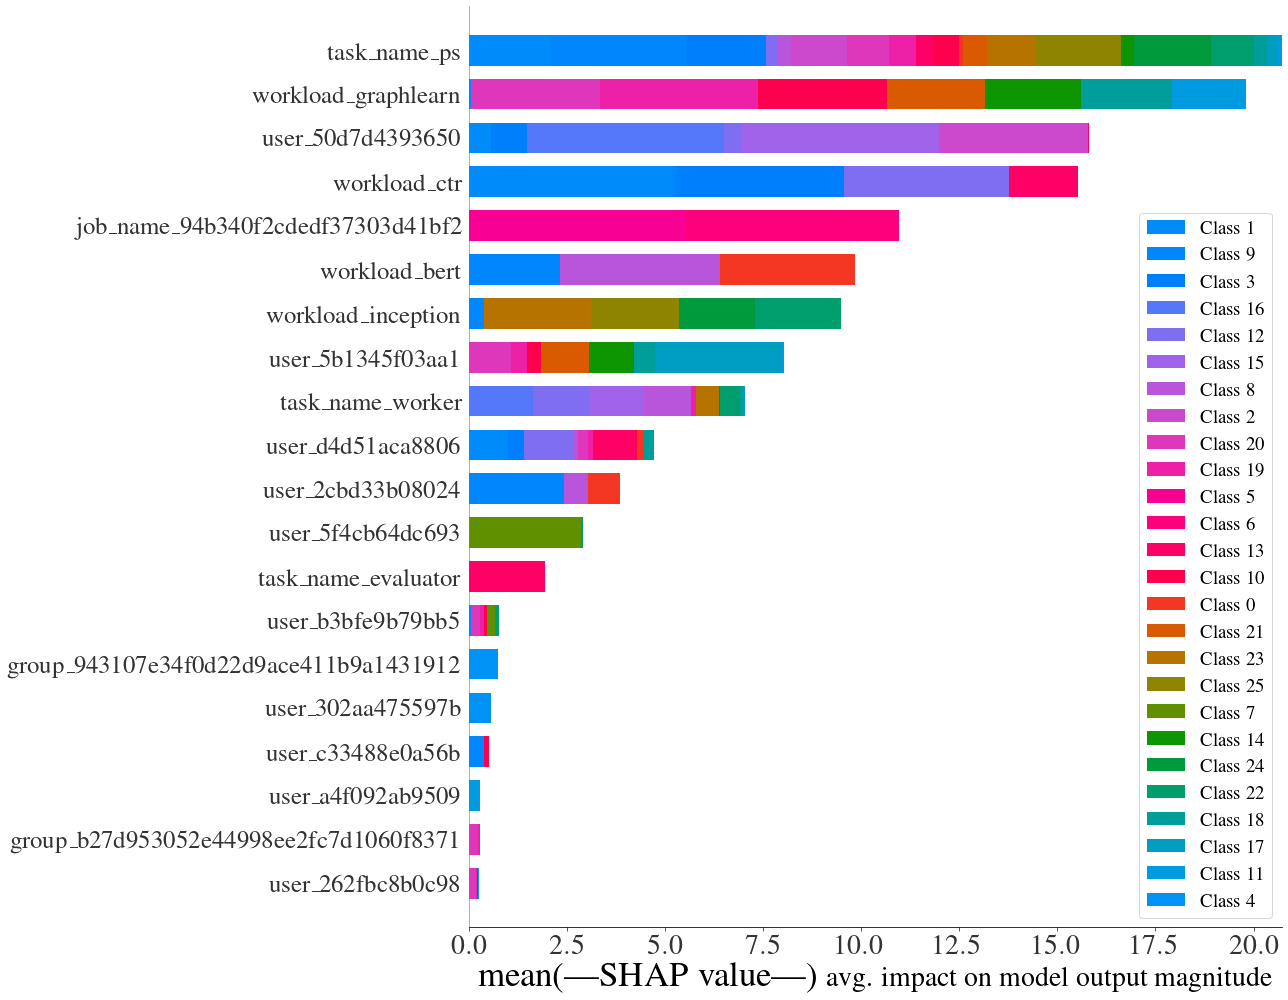

In [110]:

shap.summary_plot(shap_values, X_test_csr[:10000], feature_names=onehot_encoded_features, plot_type='bar', show=False, plot_size=[18,14])

fig, ax = plt.gcf(), plt.gca()

ax.tick_params(axis='x',labelsize=28)
ax.tick_params(axis='y',labelsize=25)
ax.legend(fontsize=19)
r'{\fontsize{50pt}{3em}\selectfont{}Write count }{\fontsize{40pt}{3em}\selectfont{}(thousands)'
ax.set_xlabel(r'{\fontsize{35pt}{3em}\selectfont{}mean(|SHAP value|){\fontsize{28pt}{3em}\selectfont{} avg. impact on model output magnitude', fontsize=30)

plt.tight_layout()
plt.savefig('Figures/NSDI_paper/SHAP_summaryplot_allclasses.pdf', format='pdf')

## Duration prediction test

In [111]:
probab_pred = [(1/ np.count_nonzero(np.array(predictions) == x)) / 25 for x in predictions]

In [112]:
np.sum(np.array(probab_pred))

1.0

In [113]:
rand_choice_index = np.random.choice(range(len(predictions)), 100, probab_pred)
rand_choice_index

array([ 6387,  4892, 14798, 14539, 14286, 10789,  5091,  8974,  5329,
         400,  5272, 11355,    94,  3307, 13040,   897,  7245,   665,
        1438, 12357,  8562,  6459,  1585, 10835,  5430,  1034, 10957,
        7198, 11431,  9370,  6651, 14831,  6511,  2123,  6394,  1837,
         893,   701,  1444, 12117,  4486,  1614,  9885,  3235, 10253,
        5102,  5306,   343,  7113, 14126,  1803,  3878,   639, 11953,
        1396, 13370,  9759,  4398,   777, 10294,  2772,  8862, 14673,
       11025,  2595, 14349,  8112, 12080,  7829, 10123,  4208,  2510,
        7824,   723,  2427,   160,  5172,  5761,  5996,   380,   222,
       10385,  2808, 11423,  7523,   283,  3809, 14808, 14964,  4133,
       10703,  9764,  6887,   493,  3425,  4858,  9343,  9192,  6746,
       12823])

In [114]:
rand_choice_pred = [predictions[x] for x in rand_choice_index]

In [115]:
rand_choice_true_y = rand_choice_pred = [y_test[x] for x in rand_choice_index]

In [116]:
rand_choice_pred == rand_choice_true_y

True

In [117]:
for x in sorted(Counter(rand_choice_pred).items()):
    print(str(x[0])+'\t'+str(x[1]))

0	4
1	5
2	2
3	4
5	2
8	15
9	19
12	7
13	1
14	1
16	1
17	1
19	3
20	3
22	4
23	11
24	1
25	16


In [118]:
df = pd.DataFrame(dict(duration=sampled_workload_data["duration"], clusters=[str(x) for x in hdbscan_clusterer.labels_]))

In [119]:
rand_choice_duration_pred = [np.mean(df[df.clusters == str(x)]['duration'].values) for x in rand_choice_pred]

In [121]:
X_train_orig[X_train_orig.index == rand_choice_pred[0]].duration.values[0]

251.0

In [122]:
def rmse_perc_eps(y_true, y_pred):
    loss = np.sqrt(mean_squared_error(y_true, y_pred))
    mean_target = np.mean(y_true)
    if abs(mean_target) <  np.finfo('float').eps:
        loss = loss / np.finfo('float').eps
    else:
        loss = loss / mean_target
    return loss

In [123]:
X_train_orig

,job_name,inst_id,user,task_name,inst_num,status,start_time,end_time,plan_cpu,plan_mem,plan_gpu,gpu_type,group,workload,inst_name,worker_name,machine,gpu_name,cpu_usage,gpu_wrk_util,avg_mem,max_mem,avg_gpu_wrk_mem,max_gpu_wrk_mem,read,write,read_count,write_count,duration
56524,1641e912395c7694c22427ec,93a6fe9eb9902c70454c89277c56298b3eb793eac6548e...,b3bfe9b79bb5,ps,40.0,Terminated,4712593.0,4714187.0,600.0,9.765625,NaN,NaN,b27d953052e44998ee2fc7d1060f8371,graphlearn,282a7cf7401767970916d5d4e1de4d7af05a2ed0adb62d...,3f5eac28f27358595cfa4987213ee4be0675272b4593cd...,0588eaef6c3fa7cfa941def2,/dev/nvidia1,80.919463,1.667774,11.708499,12.779297,0.311228,0.389648,4.283107e+07,5.328839e+07,5887.165563,54737.990066,1594.0
35320,cc6725754879a622f5cd9b8a,95ef1934eed675f4ea195b7da935e8d98b2c909c5fd2d1...,d4d51aca8806,ps,1.0,Terminated,5482926.0,5482940.0,100.0,2.000000,NaN,NaN,abc032d69ec7ff2ff05a4b44f0fb8167,ctr,1eb961a09feda641c1b7e2af96e804d070647bc0539780...,1970a725882789c266d5edb303c23a8875303f22159856...,851373f8f67d6820384166db,/dev/nvidia0,43.714286,0.000000,0.281372,0.697266,0.066895,0.133789,1.779047e+07,9.034516e+06,5291.400000,1078.500000,14.0
86168,a83055e88367caac3b631f00,ef85c6ad7bfd39ca8718c62c6ddec8da4532e7ebdd126e...,b3bfe9b79bb5,worker,50.0,Terminated,4579472.0,4579686.0,400.0,19.531250,50.0,MISC,8701a1dafcdcb4b1ac786605f20429a0,inception,04bfbf3cbc52e5798fe95311732226e41a8a258b8850cd...,2c808eae0decea8fec8698f6a0a7364352f9561a6122a9...,e7b3f000e98a235fa417f069,/dev/nvidia6,99.136364,4.800000,2.724202,14.935547,1.659961,4.342773,7.722572e+07,2.559606e+07,4392.846154,2240.230769,214.0
25599,446cd4921e0f00ab5ce1c2ea,12b9ec70cc7c63ebc7184b8a0c363513a8c3cb19746c74...,2cbd33b08024,ps,2.0,Terminated,5521030.0,5526746.0,600.0,20.000000,NaN,NaN,4ac7f9c48a6913dfa81169f7d6a150fa,bert,e828ec40b9801a3ac966bda6935e41f9877f848313be9e...,e0940246e65f1a1a8866a57dbf01b9759a9f32d26ed585...,3f000e8884972b049f5621d6,/dev/nvidia0,31.387954,9.416446,2.515187,3.136719,0.658192,0.827148,7.566791e+05,1.520753e+05,200.418358,179.360989,5716.0
33072,a27f6208d7fb6db901723d6f,9458448d63140d45db6695be22263706977bf66eaa9b82...,d4d51aca8806,worker,10.0,Terminated,4846671.0,4847065.0,600.0,2.000000,25.0,T4,93e8a65da2c48e964d5df3dab7f77e5e,ctr,7f929f674bcb98835bc8bd5cf8b37fbc79bcfb05c71b05...,6bc864142171e0292bb1e4a0062531277c669418b3f4d4...,3a28081225c578f0b26a25b4,/dev/nvidia0,424.155844,4.100000,2.351575,3.290039,0.243542,0.274414,6.141043e+08,2.223012e+06,19020.012346,14122.728395,394.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76466,4f730b3834e76cf487e5bc1d,86f6006cb7467c630672d906b1e022f63b5050ead69267...,b3bfe9b79bb5,ps,1.0,Terminated,6013996.0,6014401.0,600.0,19.531250,NaN,NaN,cae0e8ff565fc6cf842a77828867c6ab,inception,257901ea269d2a13565d71856d2ef9a13a3077c5a104ac...,4d642d865dd589d91b7cdb02453852de882284ef85a205...,4f34d89a3e77e6407ffc6a1b,/dev/nvidia1,132.064516,16.588235,5.521603,15.428711,2.338551,4.344727,1.261561e+08,1.933224e+07,8993.800000,2816.771429,405.0
6284,ffda58459ec3e694da493a0a,2cc28d925271e0674ab41b7a55eeadd3c03b45d5bda0c8...,2cbd33b08024,worker,400.0,Terminated,5859500.0,5861147.0,600.0,29.296875,25.0,MISC,02a6709662bff12fea88270e3eb1231d,bert,63142c5c493c416c9e3b240668e4e835c91d3d8d38868d...,82117dfbd74e59ab9b687a99693aeaf19ddbc77ca969de...,e64a6196dbaebd8ecf45b1b2,/dev/nvidia5,30.692308,6.660550,1.061520,2.695312,0.251678,0.713867,2.029614e+06,3.805910e+05,410.914634,221.768293,1647.0
23204,85b566fe27e2ff33e5043150,d235687ae87891d33bd532ac59e51cc19251d21a31f5a6...,2cbd33b08024,worker,400.0,Terminated,4184125.0,4187049.0,600.0,29.296875,25.0,P100,4ac7f9c48a6913dfa81169f7d6a150fa,bert,bda8afa4155acd6b934d699f10551178f21c6c61140353...,ed4113ff0948b693114f97f7d3fc887388f4cb3261e6b0...,01a75ccce109334a5e06c899,/dev/nvidia5,73.506446,15.435897,2.663656,3.002930,0.733744,0.827148,2.099783e+06,2.836255e+05,306.819013,261.943327,2924.0
21175,41ad20227c

In [124]:
from sklearn.metrics import mean_squared_error

In [125]:
def rmse_perc_eps(y_true, y_pred):
    loss = np.sqrt(mean_squared_error(y_true, y_pred))
    mean_target = np.mean(y_true)
    if abs(mean_target) <  np.finfo('float').eps:
        loss = loss / np.finfo('float').eps
    else:
        loss = loss / mean_target
    return loss


In [126]:
rmse_perc_eps([100], [101]) * 100

1.0

In [127]:
X_test_orig_reset = X_test_orig.reset_index()

In [131]:
rand_choice_duration_true = X_test_orig_reset[X_test_orig_reset.index.isin(rand_choice_pred)]['duration'].values

In [133]:
rmse_perc_single = []
for x in range(len(rand_choice_pred)):
    rmse_perc_single.append(rmse_perc_eps(y_true=[rand_choice_duration_true[x]], y_pred=[rand_choice_duration_pred[x]]))

IndexError: index 18 is out of bounds for axis 0 with size 18

In [134]:
ecdf = ECDF(rmse_perc_single)

x = np.logspace(np.log10(min(rmse_perc_single)), np.log10(max(rmse_perc_single)), 1_000)

y = ecdf(x)

x = np.concatenate( (np.array([min(rmse_perc_single)]), x) )
y = np.concatenate( (np.array([0]), y) )

idx = np.abs(x - 15).argmin()
print(x[idx], y[idx])

NameError: name 'ECDF' is not defined

4.986037759091313 0.8333333333333333


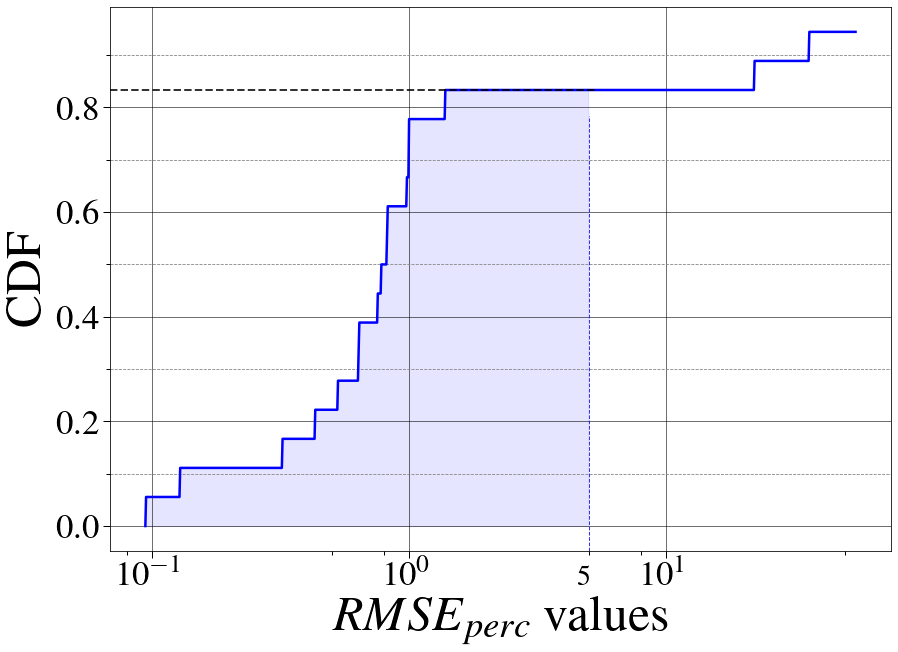

In [135]:
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib.ticker import MultipleLocator,LogLocator, NullFormatter

ecdf = ECDF(rmse_perc_single)

x = np.logspace(np.log10(min(rmse_perc_single)), np.log10(max(rmse_perc_single)), 1_000)

y = ecdf(x)

x = np.concatenate( (np.array([min(rmse_perc_single)]), x) )
y = np.concatenate( (np.array([0]), y) )

idx = np.abs(x - 5).argmin()
print(x[idx], y[idx])

fig, ax = plt.subplots(figsize=(14,10))


plt.plot(x, y, linewidth=2.5, color='blue')
plt.xscale('log')

plt.axhline(y[idx], xmax=(idx / len(x)), color='k', alpha=0.8, linewidth=2, linestyle='--')
plt.fill_between(x[:idx+1], y[:idx+1], alpha=0.1, color='blue')

ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_formatter('{x:.1f}')
# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

locmin = LogLocator(base=10.0,subs=(0.1,0.5,0.8), numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(NullFormatter())


plt.grid(axis='both', which='major', color='k', alpha=0.7, linestyle='-')
plt.grid(axis='y', which='minor', color='grey', linestyle='--')

plt.xlabel(r'$RMSE_{perc}$ values', fontsize=50)
plt.ylabel(r'CDF', fontsize=50)

plt.tick_params(which='major', width=1, length=7, labelsize=35)
plt.tick_params(which='minor', width=1, length=4)

plt.axvline(5, ymax=0.8, color='blue', alpha=0.8, linewidth=1, linestyle='--')

plt.text(4.5, -0.1125,
         r'5',
         fontsize=(28))

plt.savefig('Figures/NSDI_paper/CDF_duration_pred_100.pdf', format='pdf', bbox_inches='tight')

In [136]:
(rand_choice_duration_pred[3], rand_choice_duration_true[3])

(725.1022697962342, 1979.0)

In [137]:
from matplotlib.patches import Circle, Ellipse

my_order = [str(x) for x in sorted(list(set(rand_choice_pred)))]

df_rand_choice_rmse = pd.DataFrame(dict(profile=rand_choice_pred, rmse_perc=rmse_perc_single))
df_rand_choice_rmse.profile = df_rand_choice_rmse.profile.astype('string')

fig, ax = plt.subplots(figsize=(14,10))

    

plt.axvline(100, color='green')
plt.axvline(5, color='green', linestyle='--', linewidth=1)

plt.fill_between(range(100), [len(my_order)+10]*100, color='green', alpha=0.1)

sns.boxplot(y='profile', x='rmse_perc', data=df_rand_choice_rmse, order=my_order)

for el in df_rand_choice_rmse[df_rand_choice_rmse.rmse_perc > 100].values:
    print(el[0], my_order.index(el[0]), el[1])
    ax.add_patch(Ellipse((el[1], my_order.index(el[0])), 30, 1, edgecolor='red', linewidth=2, facecolor='white'))


ax.xaxis.set_major_locator(MultipleLocator(200))
ax.xaxis.set_major_formatter('{x:.0f}')
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.xaxis.set_minor_formatter('{x:.0f}')

plt.grid(axis='x', which='major', color='k', alpha=0.7, linestyle='-')
plt.grid(axis='x', which='minor', color='grey', linestyle='--')

plt.xlabel(r'$RMSE_{perc}$ values', fontsize=50)
plt.ylabel(r'Profiles', fontsize=50)

plt.tick_params(which='major', width=1, length=7, labelsize=35)
plt.tick_params(which='minor', width=1, length=4 , labelsize=25)

plt.savefig('Figures/NSDI_paper/boxplot_duration_pred_100.pdf', bbox_inches='tight')

ValueError: All arrays must be of the same length

### Duration test with unseen data

In [193]:
sampled_test = pd.read_csv('experiments/1_000_sampled_test_data.csv', index_col=0)


In [194]:
sampled_test['duration'] = sampled_test.end_time - sampled_test.start_time

In [195]:
sampled_test_metadata = sampled_test[categories_static_metadata].astype("category")

In [196]:
sampled_test_metadata

,job_name,user,task_name,group,workload
0,296e0a758cf4e2d86d24b5e3,d4d51aca8806,worker,176c0cb17167e45ea2ef39683d65a7f6,bert
1,7913a1fb618c6fd3e44160b6,d4d51aca8806,worker,f401aba8943f27e334d0abed91102367,bert
2,634dce1fc5fd776f0e9b9020,d4d51aca8806,worker,d1d9df69b37e3e154b63bbe9fd272dfa,bert
3,192187a11562a0e94a4c2b63,262fbc8b0c98,PyTorchWorker,1601e325bb8c8aac8501c86da9a8306d,bert
4,0aa7e8abfe5561f2f7642784,d4d51aca8806,worker,8641a8a6b9c4f6820152cff0df26710b,bert
...,...,...,...,...,...
994,8acb3f41358c97b4a0421ef8,302aa475597b,PyTorchWorker,aa545423ec4558dad1902482e90270d2,rl
995,4f8f7c8428180245a37f32cf,dbb3d4806d21,worker,5d778b276b7c44c43e63c1039394fe74,xlnet
996,392157af36a7355ae85fbdb9,47baba33cffe,ps,4c09adf369ee1b54f25761143e5ab445,xlnet
997,eba50f634d5c99df8f300ba1,47baba33cffe,ps,4c09adf369ee1b54f25761143e5ab445,xlnet


In [197]:
sampled_test_onehotencode = onehot_enc.transform(sampled_test_metadata)

In [198]:
sampled_test_onehotencode

<999x21547 sparse matrix of type '<class 'numpy.float64'>'
	with 3591 stored elements in Compressed Sparse Row format>

In [199]:
y_pred = model.predict(sampled_test_onehotencode) 

predictions = [round(value) for value in y_pred]

In [200]:
test_duration_pred = [np.mean(df[df.clusters == str(x)]['duration'].values) for x in predictions]

In [201]:
test_rmse_perc_single = []
for x in range(len(test_duration_pred)):
    test_rmse_perc_single.append(rmse_perc_eps(y_true=[sampled_test['duration'].values[x]], y_pred=[test_duration_pred[x]]))

In [202]:
test_rmse_perc_single

[0.03680821119663873,
 3.025765774018748,
 2.3745684737718755,
 0.6248896608224247,
 2.4485950537293215,
 0.9394284589847252,
 0.011377225213941885,
 0.6143590939437596,
 0.7964978807126734,
 0.05670782353874437,
 3.4834124443944257,
 0.4570214334139499,
 4.939247036978276,
 33.674465051600926,
 4.693242721837164,
 14.118066762498003,
 12.895281950825371,
 0.5356380212401155,
 0.726062427294013,
 10.182002043267754,
 12.944319130296822,
 11.828773599873076,
 0.14777854739549978,
 3.859383939345862,
 4.659753058767533,
 0.9920455900424032,
 2.2179197992992665,
 3.050928928857986,
 4.693242721837164,
 1.351908332684817,
 4.727131071371909,
 0.5133242185177134,
 26.190767558449647,
 0.8164170921598014,
 0.555379842887948,
 2.4734946570053458,
 1.6843158314094466,
 13.050247920537178,
 0.2794572412405216,
 13.706290624998058,
 1.4861964340839295,
 12.546654805105737,
 2.02845888671835,
 0.880950504826716,
 8.617090815838424,
 30.49597242187084,
 4.727131071371909,
 1.4996803509421301,
 0.0

In [203]:
ecdf = ECDF(test_rmse_perc_single)

x = np.logspace(np.log10(min(test_rmse_perc_single)), np.log10(max(test_rmse_perc_single)), 1_000)

y = ecdf(x)

x = np.concatenate( (np.array([min(test_rmse_perc_single)]), x) )
y = np.concatenate( (np.array([0]), y) )

idx = np.abs(x - 15).argmin()
print(x[idx], y[idx])

15.088699312850682 0.9419419419419419


5.006257044111679 0.8038038038038038


Text(4.5, -0.1125, '5')

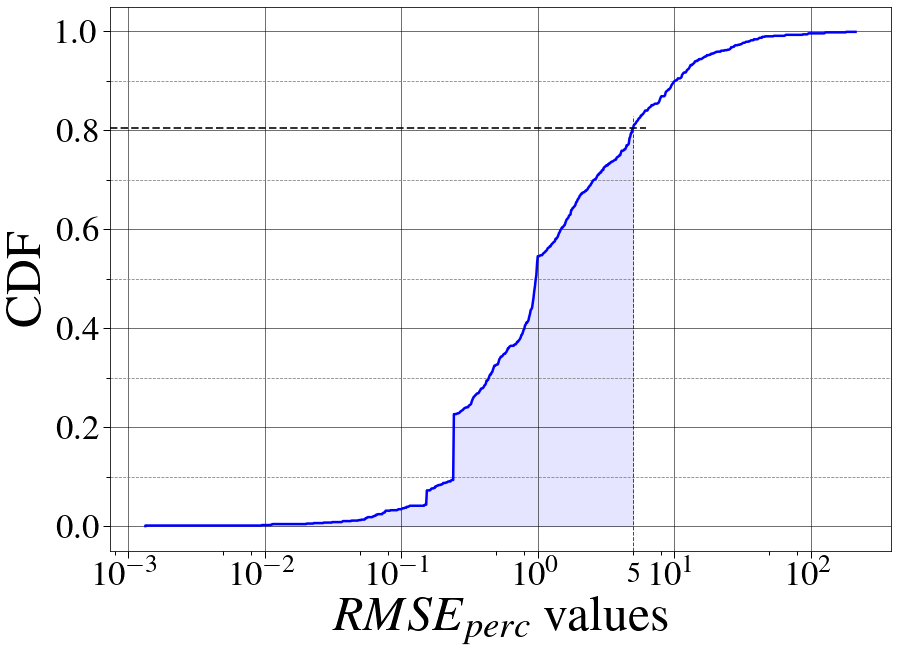

In [206]:
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib.ticker import MultipleLocator,LogLocator, NullFormatter

ecdf = ECDF(test_rmse_perc_single)

x = np.logspace(np.log10(min(test_rmse_perc_single)), np.log10(max(test_rmse_perc_single)), 1_000)

y = ecdf(x)

x = np.concatenate( (np.array([min(test_rmse_perc_single)]), x) )
y = np.concatenate( (np.array([0]), y) )

idx = np.abs(x - 5).argmin()
print(x[idx], y[idx])

fig, ax = plt.subplots(figsize=(14,10))


plt.plot(x, y, linewidth=2.5, color='blue')
plt.xscale('log')

plt.axhline(y[idx], xmax=(idx / len(x)), color='k', alpha=0.8, linewidth=2, linestyle='--')
plt.fill_between(x[:idx+1], y[:idx+1], alpha=0.1, color='blue')

ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_formatter('{x:.1f}')
# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

locmin = LogLocator(base=10.0,subs=(0.1,0.5,0.8), numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(NullFormatter())


plt.grid(axis='both', which='major', color='k', alpha=0.7, linestyle='-')
plt.grid(axis='y', which='minor', color='grey', linestyle='--')

plt.xlabel(r'$RMSE_{perc}$ values', fontsize=50)
plt.ylabel(r'CDF', fontsize=50)

plt.tick_params(which='major', width=1, length=7, labelsize=35)
plt.tick_params(which='minor', width=1, length=4)

plt.axvline(5, ymax=0.8, color='blue', alpha=0.8, linewidth=1, linestyle='--')

plt.text(4.5, -0.1125,
         r'5',
         fontsize=(28))

#plt.savefig('Figures/NSDI_paper/CDF_test_duration_pred_1_000.pdf', format='pdf', bbox_inches='tight')

12 5 127.3345864388293
12 5 180.60554684739995
12 5 129.0688376069216
21 10 213.6122687439143


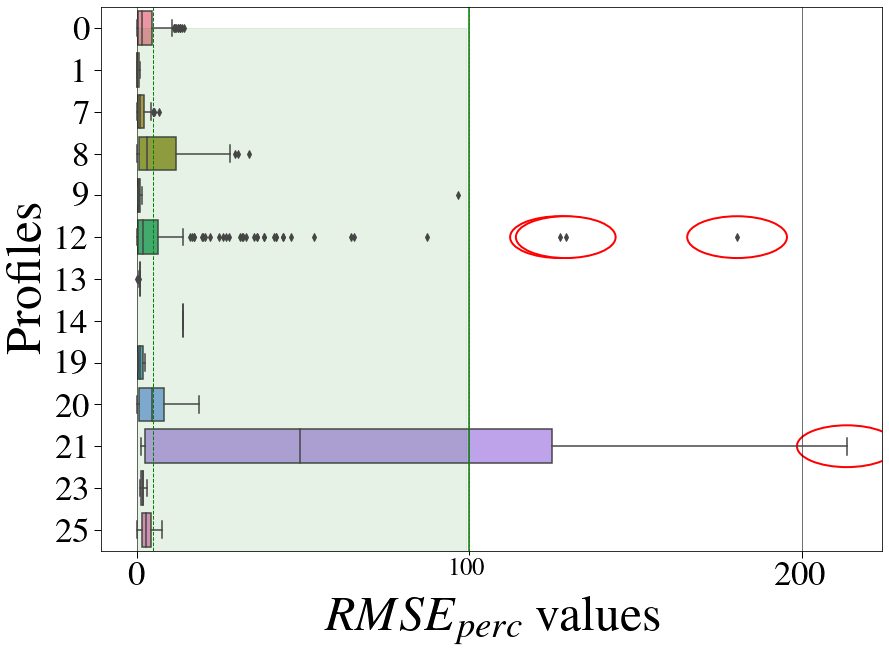

In [207]:
from matplotlib.patches import Circle, Ellipse

my_order = [str(x) for x in sorted(list(set(predictions)))]

df_test_rmse = pd.DataFrame(dict(profile=predictions, rmse_perc=test_rmse_perc_single))
df_test_rmse.profile = df_test_rmse.profile.astype('string')

fig, ax = plt.subplots(figsize=(14,10))

    

plt.axvline(100, color='green')
plt.axvline(5, color='green', linestyle='--', linewidth=1)

plt.fill_between(range(100), [len(my_order)+10]*100, color='green', alpha=0.1)

sns.boxplot(y='profile', x='rmse_perc', data=df_test_rmse, order=my_order)

for el in df_test_rmse[df_test_rmse.rmse_perc > 100].values:
    print(el[0], my_order.index(el[0]), el[1])
    ax.add_patch(Ellipse((el[1], my_order.index(el[0])), 30, 1, edgecolor='red', linewidth=2, facecolor='white'))


ax.xaxis.set_major_locator(MultipleLocator(200))
ax.xaxis.set_major_formatter('{x:.0f}')
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.xaxis.set_minor_formatter('{x:.0f}')

plt.grid(axis='x', which='major', color='k', alpha=0.7, linestyle='-')
plt.grid(axis='x', which='minor', color='grey', linestyle='--')

plt.xlabel(r'$RcMSE_{perc}$ values', fontsize=50)
plt.ylabel(r'Profiles', fontsize=50)

plt.tick_params(which='major', width=1, length=7, labelsize=35)
plt.tick_params(which='minor', width=1, length=4 , labelsize=25)

plt.savefig('Figures/NSDI_paper/boxplot_test_duration_pred_1_000.pdf', bbox_inches='tight')

(0.0, 50000.0)

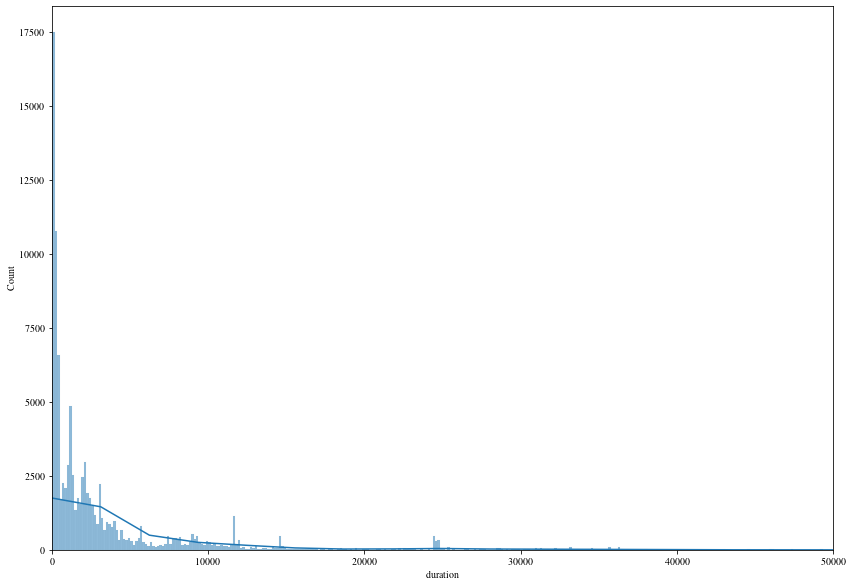

In [208]:
fig, ax = plt.subplots(figsize=(14,10))

sns.histplot(data=sampled_workload_data, x="duration", kde=True)
plt.xlim(0, 50_000)

(0.0, 50000.0)

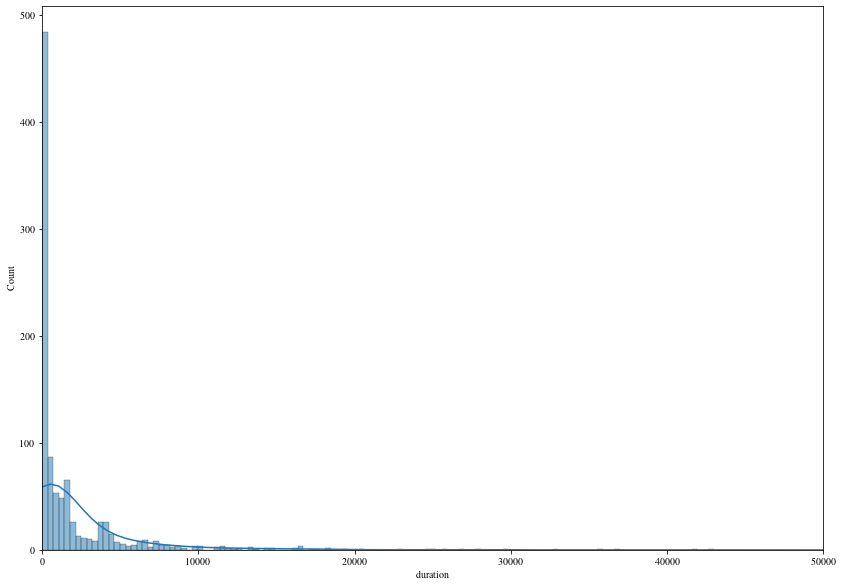

In [209]:
fig, ax = plt.subplots(figsize=(14,10))

sns.histplot(data=sampled_test, x="duration", kde=True)
plt.xlim(0, 50_000)

In [176]:
import statsmodels.api as sm

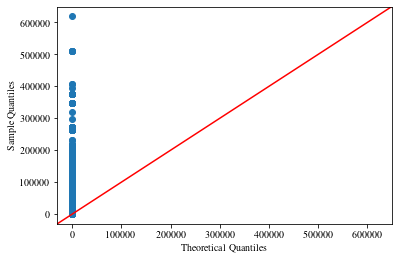

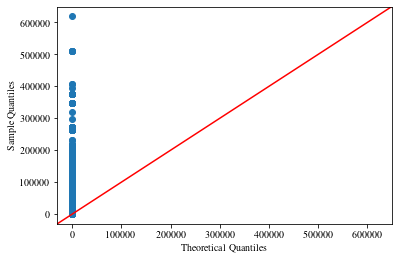

In [177]:
sm.qqplot(sampled_workload_data["duration"], line='45')


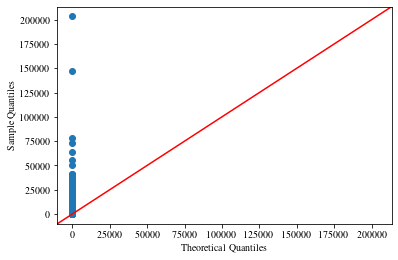

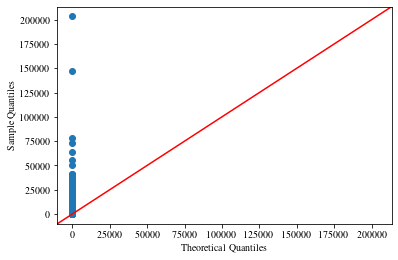

In [178]:
sm.qqplot(sampled_test["duration"], line='45')


(0.0, 10000.0)

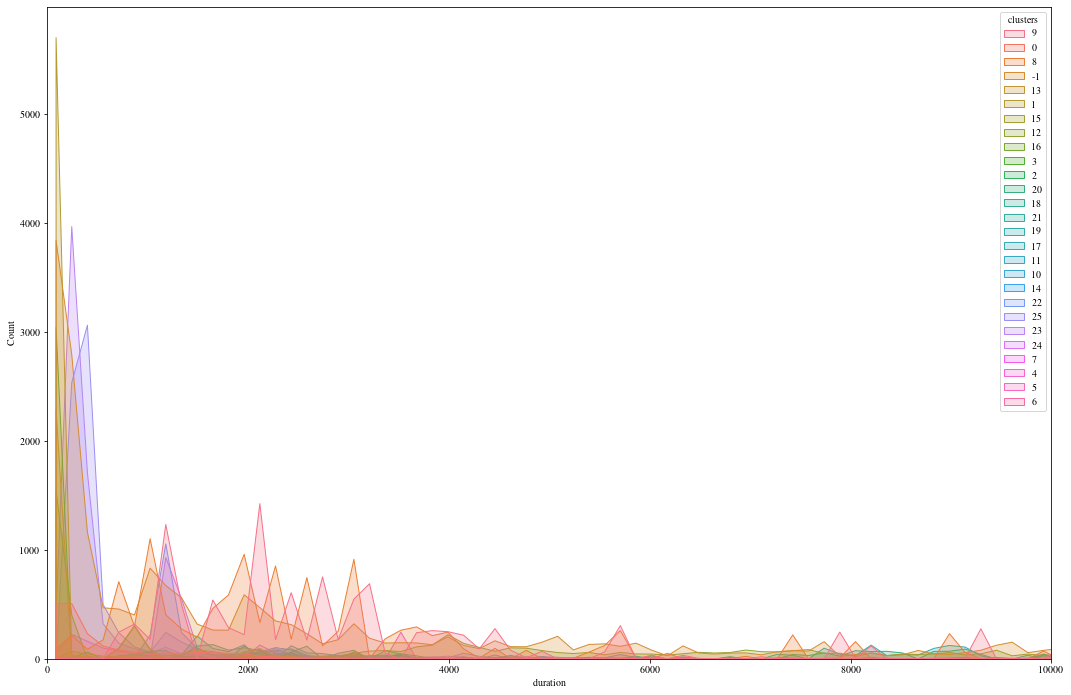

In [185]:
fig, ax = plt.subplots(figsize=(18,12))


sns.histplot(df, x='duration', hue='clusters', element='poly')
plt.xlim(0, 10_000)

### Try 

In [210]:
sampled_workload_data_clusters = sampled_workload_data.copy()

sampled_workload_data_clusters['clusters'] = df['clusters']

In [211]:
test_cpu_pred = [np.mean(sampled_workload_data_clusters[sampled_workload_data_clusters.clusters == str(x)]['cpu_usage'].values) for x in predictions]

In [212]:
len(test_cpu_pred)

999

In [213]:
test_rmse_cpu_perc_single = []
for x in range(len(test_cpu_pred)):
    test_rmse_cpu_perc_single.append(rmse_perc_eps(y_true=[sampled_test['cpu_usage'].values[x]], y_pred=[test_cpu_pred[x]]))

5.023138256068683 0.974974974974975


Text(4.5, -0.1125, '5')

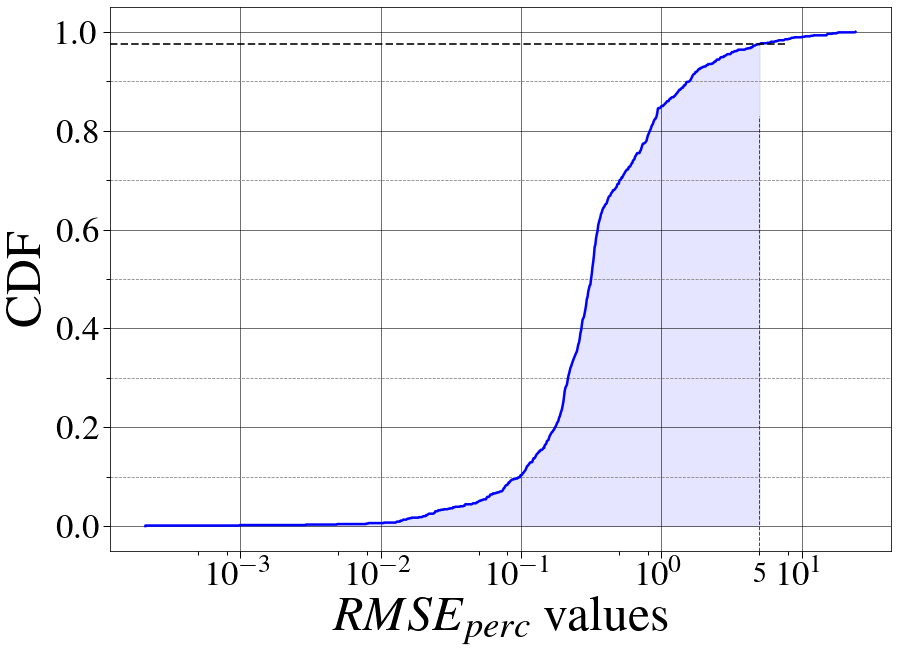

In [214]:
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib.ticker import MultipleLocator,LogLocator, NullFormatter

ecdf = ECDF(test_rmse_cpu_perc_single)

x = np.logspace(np.log10(min(test_rmse_cpu_perc_single)), np.log10(max(test_rmse_cpu_perc_single)), 1_000)

y = ecdf(x)

x = np.concatenate( (np.array([min(test_rmse_cpu_perc_single)]), x) )
y = np.concatenate( (np.array([0]), y) )

idx = np.abs(x - 5).argmin()
print(x[idx], y[idx])

fig, ax = plt.subplots(figsize=(14,10))


plt.plot(x, y, linewidth=2.5, color='blue')
plt.xscale('log')

plt.axhline(y[idx], xmax=(idx / len(x)), color='k', alpha=0.8, linewidth=2, linestyle='--')
plt.fill_between(x[:idx+1], y[:idx+1], alpha=0.1, color='blue')

ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_formatter('{x:.1f}')
# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

locmin = LogLocator(base=10.0,subs=(0.1,0.5,0.8), numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(NullFormatter())


plt.grid(axis='both', which='major', color='k', alpha=0.7, linestyle='-')
plt.grid(axis='y', which='minor', color='grey', linestyle='--')

plt.xlabel(r'$RMSE_{perc}$ values', fontsize=50)
plt.ylabel(r'CDF', fontsize=50)

plt.tick_params(which='major', width=1, length=7, labelsize=35)
plt.tick_params(which='minor', width=1, length=4)

plt.axvline(5, ymax=0.8, color='blue', alpha=0.8, linewidth=1, linestyle='--')

plt.text(4.5, -0.1125,
         r'5',
         fontsize=(28))

#plt.savefig('Figures/NSDI_paper/CDF_test_duration_pred_1_000.pdf', format='pdf', bbox_inches='tight')

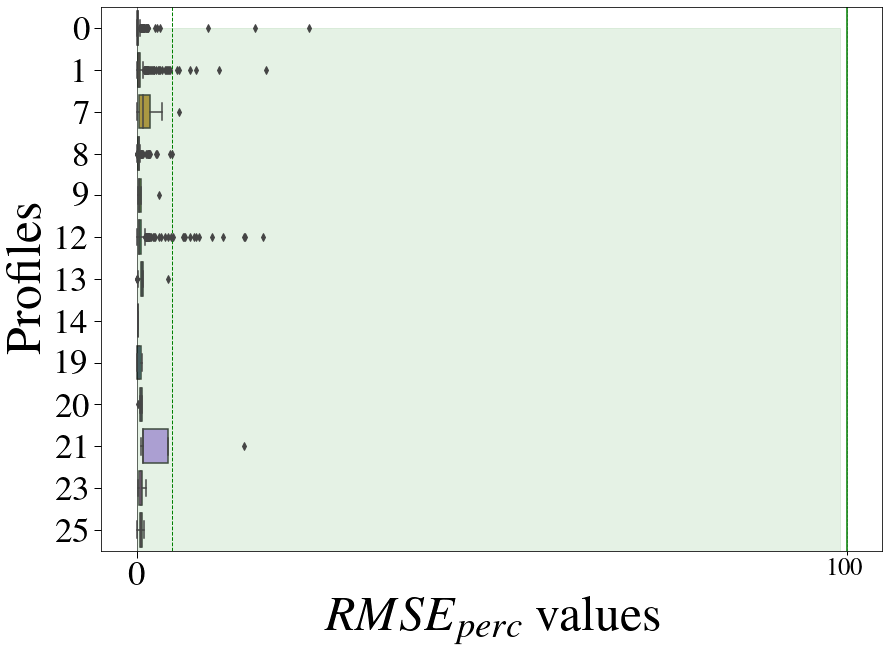

In [217]:
from matplotlib.patches import Circle, Ellipse

my_order = [str(x) for x in sorted(list(set(predictions)))]

df_test_rmse = pd.DataFrame(dict(profile=predictions, rmse_perc=test_rmse_cpu_perc_single))
df_test_rmse.profile = df_test_rmse.profile.astype('string')

fig, ax = plt.subplots(figsize=(14,10))

    

plt.axvline(100, color='green')
plt.axvline(5, color='green', linestyle='--', linewidth=1)

plt.fill_between(range(100), [len(my_order)+10]*100, color='green', alpha=0.1)

sns.boxplot(y='profile', x='rmse_perc', data=df_test_rmse, order=my_order)

for el in df_test_rmse[df_test_rmse.rmse_perc > 100].values:
    print(el[0], my_order.index(el[0]), el[1])
    ax.add_patch(Ellipse((el[1], my_order.index(el[0])), 30, 1, edgecolor='red', linewidth=2, facecolor='white'))


ax.xaxis.set_major_locator(MultipleLocator(200))
ax.xaxis.set_major_formatter('{x:.0f}')
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.xaxis.set_minor_formatter('{x:.0f}')

plt.grid(axis='x', which='major', color='k', alpha=0.7, linestyle='-')
plt.grid(axis='x', which='minor', color='grey', linestyle='--')

plt.xlabel(r'$RMSE_{perc}$ values', fontsize=50)
plt.ylabel(r'Profiles', fontsize=50)

plt.tick_params(which='major', width=1, length=7, labelsize=35)
plt.tick_params(which='minor', width=1, length=4 , labelsize=25)

#plt.savefig('Figures/NSDI_paper/boxplot_test_duration_pred_1_000.pdf', bbox_inches='tight')